<a href="https://colab.research.google.com/github/GabrielVanzuita/BRecommerce-data-procedures/blob/main/Ecommerce-Data-Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook aims to analyze and define data quality parameters, with the goal of transforming the assets into a more consumable format.

#**IMPORTING ZONE**

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import missingno as msno
import uuid
import json
from sklearn.impute import SimpleImputer




In [119]:
assets_path = '/content/content'


dataframes = {}
for filename in os.listdir(assets_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(assets_path, filename)
        try:
            key = filename[:-4]
            dataframes[key] = pd.read_csv(filepath)
            print(f"DataFrame '{key}' was created.")
        except Exception as e:
            print(f"Load error to '{filename}': {e}")


DataFrame 'olist_products_dataset' was created.
DataFrame 'olist_sellers_dataset' was created.
DataFrame 'olist_geolocation_dataset' was created.
DataFrame 'product_category_name_translation' was created.
DataFrame 'olist_order_items_dataset' was created.
DataFrame 'olist_order_payments_dataset' was created.
DataFrame 'olist_order_reviews_dataset' was created.
DataFrame 'olist_orders_dataset' was created.
DataFrame 'olist_customers_dataset' was created.


In [120]:
consumeable_dataframes = []

# **MAJOR DATA QUALITY PARAMETERS**

### **Data Quality and Source**

All information about the dataset can be found on the [official site](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

#### **Criteria for Data Quality Assessment**
1. **Accuracy:**  
   - Determining accuracy requires direct access to the original data source. This criterion will be disregarded for practical purposes.

2. **Completeness:**  
   - Completeness will be assessed directly for each dataset field.

3. **Consistency:**  
   - Consistency will be analyzed directly for each dataset field.

4. **Timeliness:**  
   - Due to the significant time gap between years, this dataset is not recommended for real-time decision-making.

5. **Availability:**  
   - The data is available for download by anyone on Kaggle.

6. **Uniqueness:**  
   - Uniqueness will be assessed directly for each dataset field.

7. **Traceability:**  
   - This criterion will not be considered necessary in this case.

In [121]:
def generate_data_profile(df: pd.DataFrame):
    """
    Generates a detailed data profile, including descritive estathistics, missing values,
    histograms and bar charts.

    Parameters:
        df (pd.DataFrame): DataFrame to be analyzed.
    """
    profile = {}

    # Style sheet
    sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
    plt.figure(figsize=(12, 6))

    # Heatmap for missing values.
    print("Analyzing values...")
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Heathmap for missing values', fontsize=16, pad=15)
    plt.show()

    # Analysis: per column
    for column in df.columns:
        print(f"\nAnalyzing columns: {column}\n{'-'*40}")
        if df[column].dtype in [np.int64, np.float64]:  # Possible numeric columns
            stats = {
                'type': 'numeric',
                'missing_values': df[column].isna().sum(),
                'mean': df[column].mean(),
                'std_dev': df[column].std(),
                'min': df[column].min(),
                'max': df[column].max(),
                'outliers': df[column][(df[column] < df[column].quantile(0.05)) |
                                       (df[column] > df[column].quantile(0.95))].count()
            }
            profile[column] = stats

            # Exhibits statistics
            print(f"Statistics:\n{stats}")

            # Vialization: histogram and boxplot.
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            sns.histplot(df[column], kde=True, ax=axes[0], color='skyblue')
            axes[0].set_title(f'Histogram ({column})', fontsize=14)
            axes[0].set_xlabel(column)

            sns.boxplot(x=df[column], ax=axes[1], color='lightgreen')
            axes[1].set_title(f'Boxplot de {column}', fontsize=14)
            axes[1].set_xlabel(column)

            plt.tight_layout()
            plt.show()

        else:  # Categorical columns
            stats = {
                'type': 'categorical',
                'missing_values': df[column].isna().sum(),
                'unique_values': df[column].nunique(),
                'most_frequent': df[column].mode()[0] if not df[column].mode().empty else None
            }
            profile[column] = stats

            # Exhibits statistics
            print(f"Statistics:\n{stats}")

            # Visualization: bar graph
            if stats['unique_values'] <= 20:  # Only categories until a limit of 20
                plt.figure(figsize=(10, 6))
                sns.countplot(data=df, y=column, order=df[column].value_counts().index, palette='pastel')
                plt.title(f'Bar graph ({column})', fontsize=16)
                plt.xlabel('Count')
                plt.ylabel(column)
                plt.show()
            else:
                print(f"The column {column} has more than 20 unique values.")

    return profile

In [122]:
def check_duplicates(df, column):
    duplicates = df[df.duplicated(subset=[column], keep=False)]
    return len(duplicates), duplicates

def check_missing_values(df):
    return df.isna().sum()

In [123]:
def data_type_consistency(df):
    df_info = pd.DataFrame(df.dtypes, columns=['Data Type'])
    return df_info

In [124]:
def data_type_to_categorical(df, column):
    df[column] = df[column].astype('category')
    return df

def data_type_to_uuid(df, column):
    df[column] = df[column].apply(lambda x: uuid.UUID(str(x)))
    return df

def data_type_to_string(df, column):
    df[column] = df[column].astype('string')
    return df

def data_type_to_datetime(df, column):
    df[column] = pd.to_datetime(df[column])
    return df

def data_type_to_int(df, column, bits):
    df[column] = df[column].astype(f'int{bits}')
    return df

# **DATA ASSETS**

##Sellers


In [125]:
sellers = dataframes['olist_sellers_dataset']

In [126]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


**Data profile:**

Analyzing values...


<Figure size 1200x600 with 0 Axes>

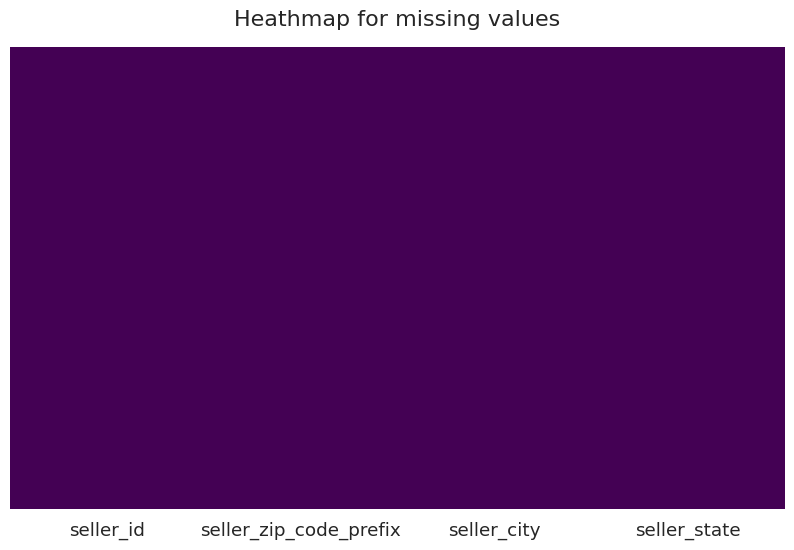


Analyzing columns: seller_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 3095, 'most_frequent': '0015a82c2db000af6aaaf3ae2ecb0532'}
The column seller_id has more than 20 unique values.

Analyzing columns: seller_zip_code_prefix
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(32291.059450726978), 'std_dev': 32713.45382950907, 'min': 1001, 'max': 99730, 'outliers': np.int64(310)}


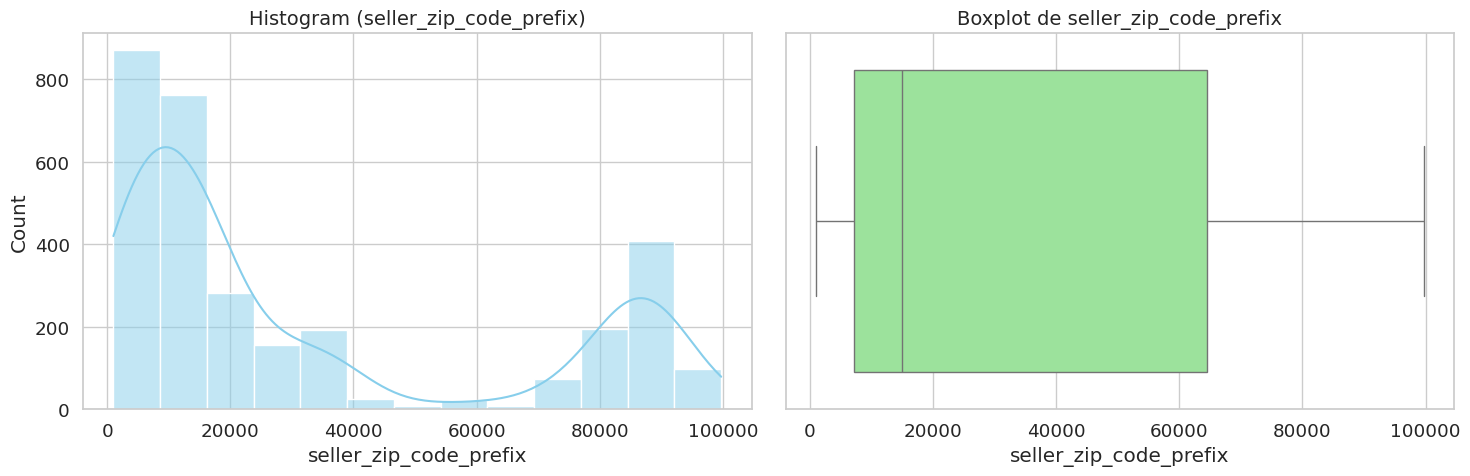


Analyzing columns: seller_city
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 611, 'most_frequent': 'sao paulo'}
The column seller_city has more than 20 unique values.

Analyzing columns: seller_state
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 23, 'most_frequent': 'SP'}
The column seller_state has more than 20 unique values.


{'seller_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 3095,
  'most_frequent': '0015a82c2db000af6aaaf3ae2ecb0532'},
 'seller_zip_code_prefix': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(32291.059450726978),
  'std_dev': 32713.45382950907,
  'min': 1001,
  'max': 99730,
  'outliers': np.int64(310)},
 'seller_city': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 611,
  'most_frequent': 'sao paulo'},
 'seller_state': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 23,
  'most_frequent': 'SP'}}

In [127]:
generate_data_profile (sellers)

**The Seller ID column is uniquely constrained, ensuring no duplicate values (Complitude 100%):**

In [128]:
check_duplicates(sellers, 'seller_id')

(0,
 Empty DataFrame
 Columns: [seller_id, seller_zip_code_prefix, seller_city, seller_state]
 Index: [])

**There is no missing values:**

In [129]:
check_missing_values(sellers)

,0
seller_id,0
seller_zip_code_prefix,0
seller_city,0
seller_state,0


**Verifying data type consistency:**

In [130]:
d_type_sellers = data_type_consistency (sellers)
d_type_sellers

,Data Type
seller_id,object
seller_zip_code_prefix,int64
seller_city,object
seller_state,object


**Creating consumeable dataframe:**

In [131]:
sellers_t = sellers.copy()

**Converting seller_id to UUID:**

In [132]:
data_type_to_uuid (sellers_t, 'seller_id')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f895-9a84-dea7-ee19-7c632cb2df15,13023,campinas,SP
1,d1b65fc7-debc-3361-ea86-b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de-9601-02d0-677a-81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2-e145-55b6-faee-a3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a-6bdc-b23d-eccc-82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4-601d-d444-3ca1-74359b237166,87111,sarandi,PR
3091,f8201cab-383e-4847-3326-6d1906e2fdfa,88137,palhoca,SC
3092,74871d19-219c-7d51-8d00-90283e03c137,4650,sao paulo,SP
3093,e603cf3f-ec55-f869-7c90-59638d6c8eb5,96080,pelotas,RS


*Supposing that the consumer had an architecture that can handle UUID*

**Setting seller_city as STR:**

In [133]:
data_type_to_string (sellers_t, 'seller_city')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f895-9a84-dea7-ee19-7c632cb2df15,13023,campinas,SP
1,d1b65fc7-debc-3361-ea86-b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de-9601-02d0-677a-81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2-e145-55b6-faee-a3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a-6bdc-b23d-eccc-82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4-601d-d444-3ca1-74359b237166,87111,sarandi,PR
3091,f8201cab-383e-4847-3326-6d1906e2fdfa,88137,palhoca,SC
3092,74871d19-219c-7d51-8d00-90283e03c137,4650,sao paulo,SP
3093,e603cf3f-ec55-f869-7c90-59638d6c8eb5,96080,pelotas,RS


**Setting seller_city as PD Category:**

In [134]:
data_type_to_categorical (sellers_t, 'seller_state')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f895-9a84-dea7-ee19-7c632cb2df15,13023,campinas,SP
1,d1b65fc7-debc-3361-ea86-b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de-9601-02d0-677a-81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2-e145-55b6-faee-a3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a-6bdc-b23d-eccc-82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4-601d-d444-3ca1-74359b237166,87111,sarandi,PR
3091,f8201cab-383e-4847-3326-6d1906e2fdfa,88137,palhoca,SC
3092,74871d19-219c-7d51-8d00-90283e03c137,4650,sao paulo,SP
3093,e603cf3f-ec55-f869-7c90-59638d6c8eb5,96080,pelotas,RS


**Setting zip_code as STR:**

In [135]:
data_type_to_string (sellers_t, 'seller_zip_code_prefix')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f895-9a84-dea7-ee19-7c632cb2df15,13023,campinas,SP
1,d1b65fc7-debc-3361-ea86-b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de-9601-02d0-677a-81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2-e145-55b6-faee-a3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a-6bdc-b23d-eccc-82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4-601d-d444-3ca1-74359b237166,87111,sarandi,PR
3091,f8201cab-383e-4847-3326-6d1906e2fdfa,88137,palhoca,SC
3092,74871d19-219c-7d51-8d00-90283e03c137,4650,sao paulo,SP
3093,e603cf3f-ec55-f869-7c90-59638d6c8eb5,96080,pelotas,RS


*Each column related to zip codes will be set as a string data type to prevent issues with leading zeros. This is a recommended practice for non-numeric, identifier-based data.*

**Checking:**

In [136]:
data_type_consistency(sellers_t)

,Data Type
seller_id,object
seller_zip_code_prefix,string[python]
seller_city,string[python]
seller_state,category


**Saving transformed dataframe:**

In [137]:
consumeable_dataframes.append(sellers_t)

## Product orders

In [138]:
orders  = dataframes['olist_order_items_dataset']

In [139]:
orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


**Data profile:**

Analyzing values...


<Figure size 1200x600 with 0 Axes>

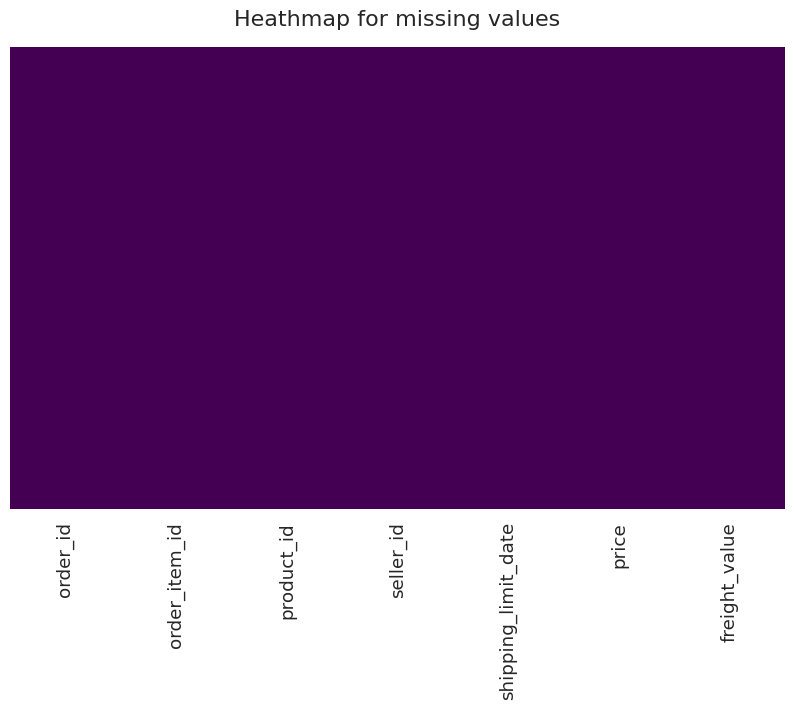


Analyzing columns: order_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 98666, 'most_frequent': '8272b63d03f5f79c56e9e4120aec44ef'}
The column order_id has more than 20 unique values.

Analyzing columns: order_item_id
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(1.1978339991122948), 'std_dev': 0.7051240313956294, 'min': 1, 'max': 21, 'outliers': np.int64(4181)}


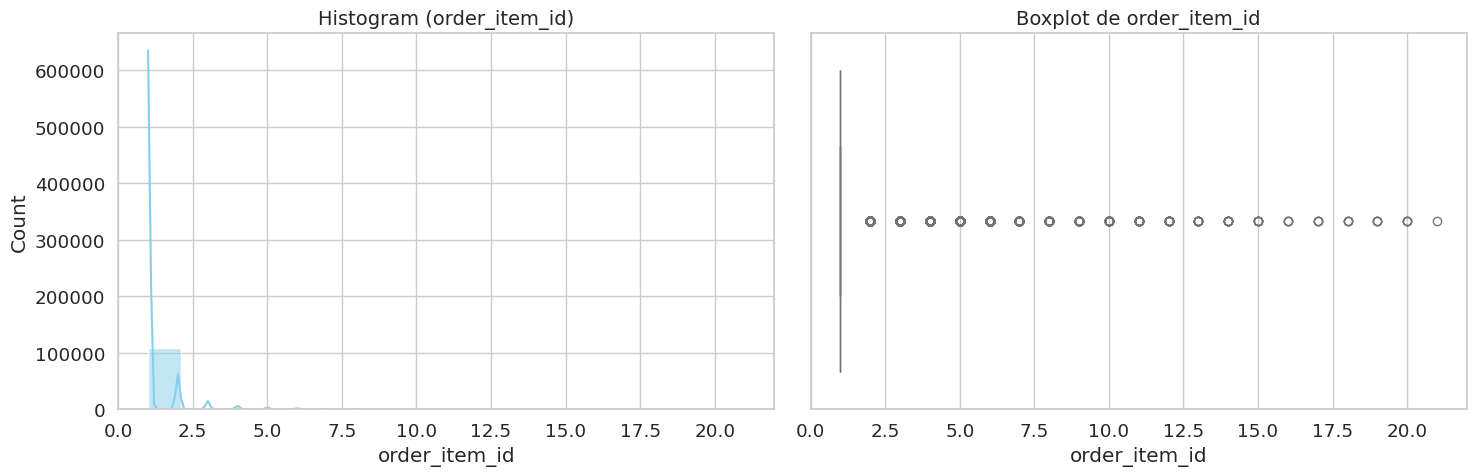


Analyzing columns: product_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 32951, 'most_frequent': 'aca2eb7d00ea1a7b8ebd4e68314663af'}
The column product_id has more than 20 unique values.

Analyzing columns: seller_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 3095, 'most_frequent': '6560211a19b47992c3666cc44a7e94c0'}
The column seller_id has more than 20 unique values.

Analyzing columns: shipping_limit_date
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 93318, 'most_frequent': '2017-07-21 18:25:23'}
The column shipping_limit_date has more than 20 unique values.

Analyzing columns: price
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(120.65373901464716), 'std_dev': 183.633

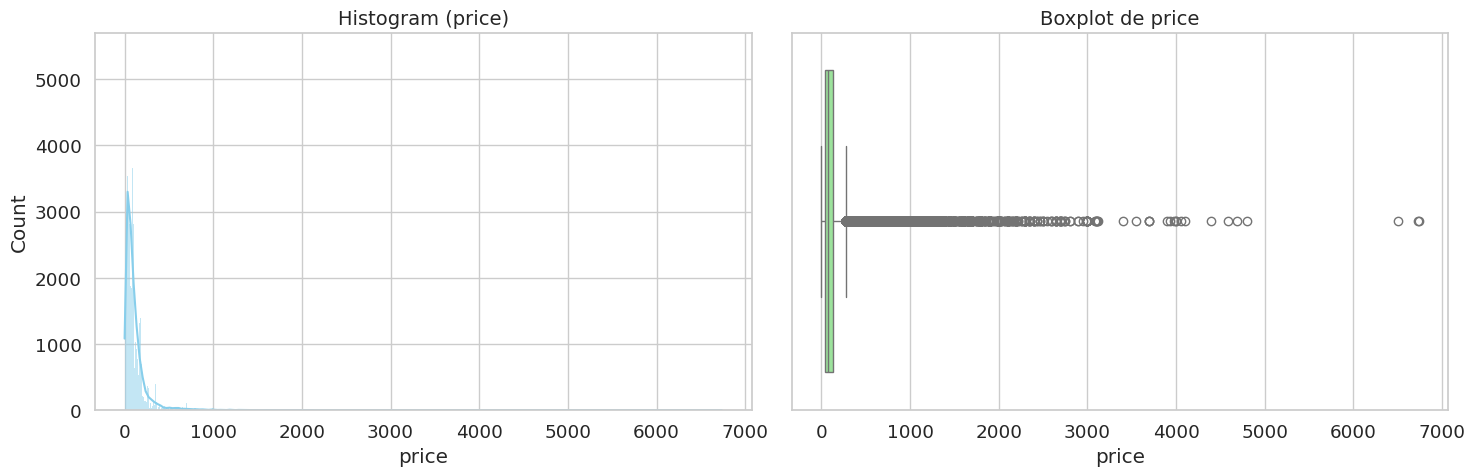


Analyzing columns: freight_value
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(19.990319928983578), 'std_dev': 15.806405412296854, 'min': 0.0, 'max': 409.68, 'outliers': np.int64(10239)}


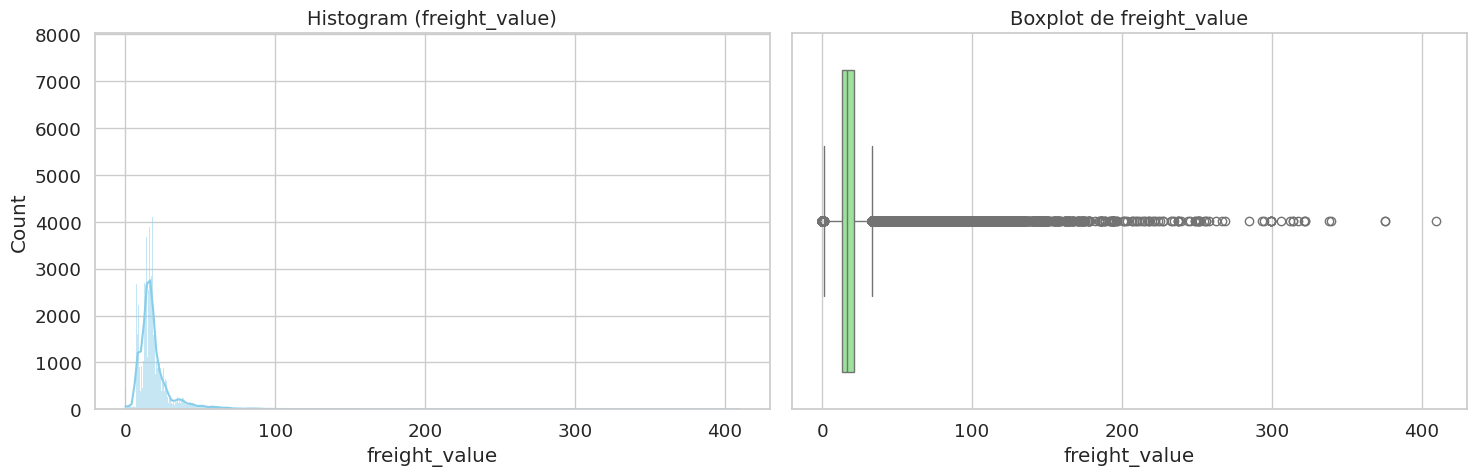

{'order_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 98666,
  'most_frequent': '8272b63d03f5f79c56e9e4120aec44ef'},
 'order_item_id': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(1.1978339991122948),
  'std_dev': 0.7051240313956294,
  'min': 1,
  'max': 21,
  'outliers': np.int64(4181)},
 'product_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 32951,
  'most_frequent': 'aca2eb7d00ea1a7b8ebd4e68314663af'},
 'seller_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 3095,
  'most_frequent': '6560211a19b47992c3666cc44a7e94c0'},
 'shipping_limit_date': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 93318,
  'most_frequent': '2017-07-21 18:25:23'},
 'price': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(120.65373901464716),
  'std_dev': 183.63392805025404,
  'min': 0.85,
  'max': 6735.0,
  'outliers': np.int

In [140]:
generate_data_profile (orders)

**Complitude = 100%:**

In [141]:
check_missing_values (orders)

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0


**Checking duplicates:**

In [142]:
check_duplicates (orders, 'order_id')

(23787,
                                 order_id  order_item_id  \
 13      0008288aa423d2a3f00fcb17cd7d8719              1   
 14      0008288aa423d2a3f00fcb17cd7d8719              2   
 32      00143d0f86d6fbd9f9b38ab440ac16f5              1   
 33      00143d0f86d6fbd9f9b38ab440ac16f5              2   
 34      00143d0f86d6fbd9f9b38ab440ac16f5              3   
 ...                                  ...            ...   
 112635  fff8287bbae429a99bb7e8c21d151c41              2   
 112640  fffb9224b6fc7c43ebb0904318b10b5f              1   
 112641  fffb9224b6fc7c43ebb0904318b10b5f              2   
 112642  fffb9224b6fc7c43ebb0904318b10b5f              3   
 112643  fffb9224b6fc7c43ebb0904318b10b5f              4   
 
                               product_id                         seller_id  \
 13      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
 14      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
 32      e95ee6822b66ac6058e2e4af

**There are not duplicates, but separated products on the same order id :**

In [143]:
orders[orders['order_id'] == 'fffb9224b6fc7c43ebb0904318b10b5f']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19
112643,fffb9224b6fc7c43ebb0904318b10b5f,4,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19


**Data type consistency:**

In [144]:
data_type_consistency (orders)

,Data Type
order_id,object
order_item_id,int64
product_id,object
seller_id,object
shipping_limit_date,object
price,float64
freight_value,float64


**Creating the consumeable dataframe:**

In [145]:
orders_t = orders.copy()

In [146]:
orders_t

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


**Changing both order_id, product_id to UIID and seller_id:**

In [147]:
data_type_to_uuid (orders_t, 'order_id')
data_type_to_uuid (orders_t, 'product_id')
data_type_to_uuid (orders_t, 'seller_id')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242-fe8c-5a6d-1ba2-dd792cb16214,1,4244733e-06e7-ecb4-970a-6e2683c13e61,48436dad-e18a-c8b2-bce0-89ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77-f2f0-320c-5571-90d7a144bdd3,1,e5f2d52b-8021-89ee-6588-65ca93d83a8f,dd7ddc04-e1b6-c2c6-1435-2b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec-3982-24ef-6ca0-657da4fc703e,1,c777355d-18b7-2b67-abbe-ef9df44fd0fd,5b51032e-ddd2-42ad-c84c-38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acb-cdf0-a6da-a1e9-31b038114c75,1,7634da15-2a46-10f1-595e-fa32f14722fc,9d7a1d34-a505-2409-0064-25275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26-cf59-d7ce-69df-abb4e55b4fd9,1,ac6c3623-068f-30de-0304-5865e4e10089,df560393-f3a5-1e74-553a-b94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6-ce00-a005-8188-0bf54a75a037,1,4aa6014e-ceb6-8207-7f9d-c4bffebc05b0,b8bc237b-a378-8b23-da09-c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46e-f226-3f40-4302-a634eb57f7eb,1,32e07fd9-1582-2b07-65e4-48c4dd74c828,f3c38ab6-5283-6d21-de61-fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce470-5a96-62cd-70ad-b13d4a31832d,1,72a30483-855e-2eaf-c67a-ee5dc2560482,c3cfdc64-8177-fdbb-bb35-635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe1854-4ffa-bc95-dfad-a21779c9644f,1,9c422a51-9119-dcad-7575-db5af1ba540e,2b3e4a2a-3ea8-e019-38ca-bda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


**Setting shipping_limit_date columns to DateTime:**

In [148]:
data_type_to_datetime (orders_t, 'shipping_limit_date')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242-fe8c-5a6d-1ba2-dd792cb16214,1,4244733e-06e7-ecb4-970a-6e2683c13e61,48436dad-e18a-c8b2-bce0-89ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77-f2f0-320c-5571-90d7a144bdd3,1,e5f2d52b-8021-89ee-6588-65ca93d83a8f,dd7ddc04-e1b6-c2c6-1435-2b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec-3982-24ef-6ca0-657da4fc703e,1,c777355d-18b7-2b67-abbe-ef9df44fd0fd,5b51032e-ddd2-42ad-c84c-38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acb-cdf0-a6da-a1e9-31b038114c75,1,7634da15-2a46-10f1-595e-fa32f14722fc,9d7a1d34-a505-2409-0064-25275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26-cf59-d7ce-69df-abb4e55b4fd9,1,ac6c3623-068f-30de-0304-5865e4e10089,df560393-f3a5-1e74-553a-b94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6-ce00-a005-8188-0bf54a75a037,1,4aa6014e-ceb6-8207-7f9d-c4bffebc05b0,b8bc237b-a378-8b23-da09-c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46e-f226-3f40-4302-a634eb57f7eb,1,32e07fd9-1582-2b07-65e4-48c4dd74c828,f3c38ab6-5283-6d21-de61-fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce470-5a96-62cd-70ad-b13d4a31832d,1,72a30483-855e-2eaf-c67a-ee5dc2560482,c3cfdc64-8177-fdbb-bb35-635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe1854-4ffa-bc95-dfad-a21779c9644f,1,9c422a51-9119-dcad-7575-db5af1ba540e,2b3e4a2a-3ea8-e019-38ca-bda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


**Checking:**

In [149]:
data_type_consistency (orders_t)

,Data Type
order_id,object
order_item_id,int64
product_id,object
seller_id,object
shipping_limit_date,datetime64[ns]
price,float64
freight_value,float64


**Saving the transformed dataframe**

In [150]:
consumeable_dataframes.append(orders_t)

## Orders

In [151]:
orders = dataframes['olist_orders_dataset']

In [152]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


**Data profile:**


Analyzing values...


<Figure size 1200x600 with 0 Axes>

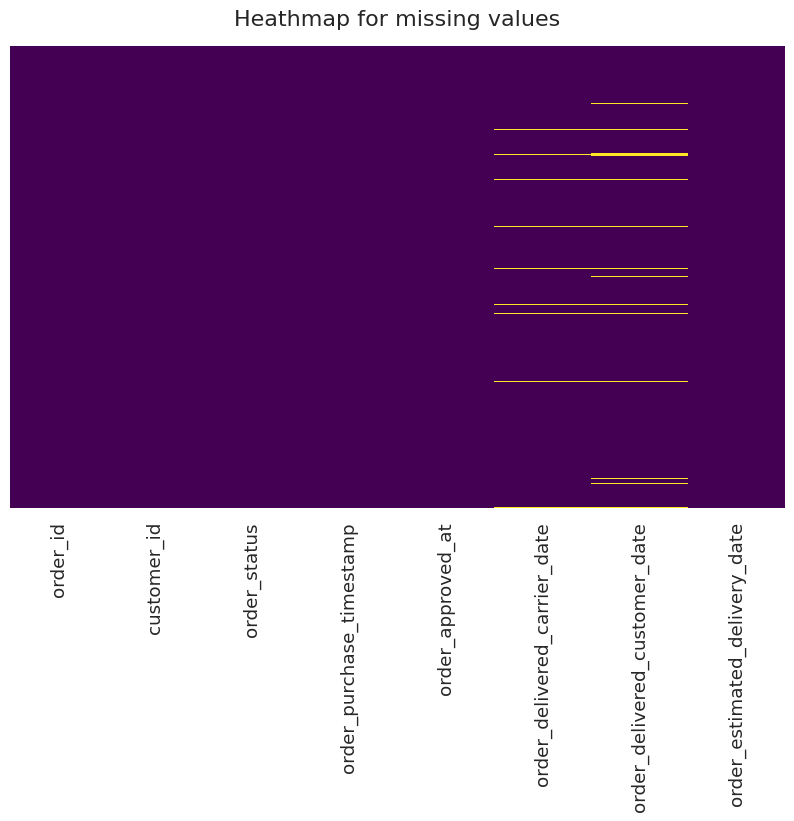


Analyzing columns: order_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 99441, 'most_frequent': '00010242fe8c5a6d1ba2dd792cb16214'}
The column order_id has more than 20 unique values.

Analyzing columns: customer_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 99441, 'most_frequent': '00012a2ce6f8dcda20d059ce98491703'}
The column customer_id has more than 20 unique values.

Analyzing columns: order_status
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 8, 'most_frequent': 'delivered'}


<ipython-input-121-f67c98861711>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df[column].value_counts().index, palette='pastel')


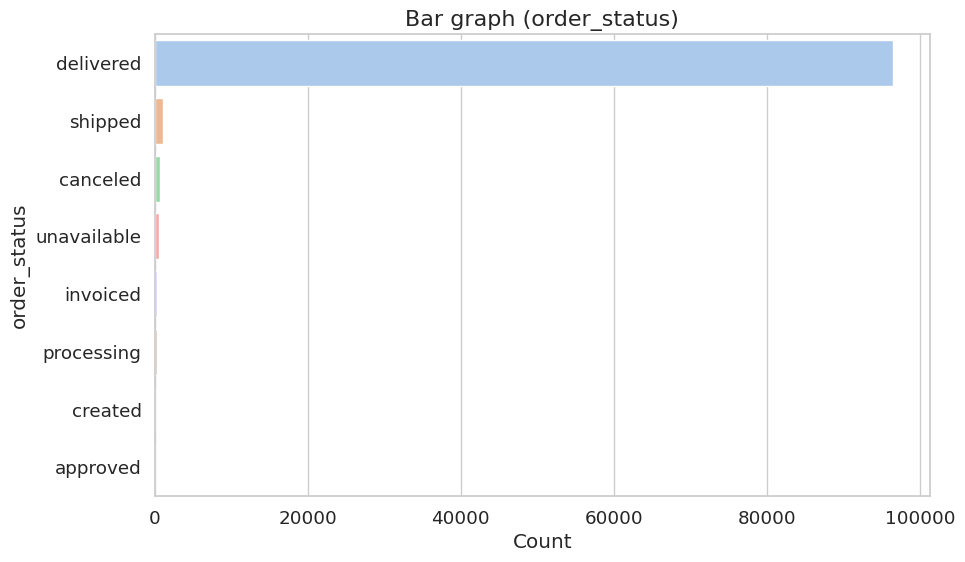


Analyzing columns: order_purchase_timestamp
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 98875, 'most_frequent': '2017-11-20 10:59:08'}
The column order_purchase_timestamp has more than 20 unique values.

Analyzing columns: order_approved_at
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(160), 'unique_values': 90733, 'most_frequent': '2018-02-27 04:31:10'}
The column order_approved_at has more than 20 unique values.

Analyzing columns: order_delivered_carrier_date
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(1783), 'unique_values': 81018, 'most_frequent': '2018-05-09 15:48:00'}
The column order_delivered_carrier_date has more than 20 unique values.

Analyzing columns: order_delivered_customer_date
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': n

{'order_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 99441,
  'most_frequent': '00010242fe8c5a6d1ba2dd792cb16214'},
 'customer_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 99441,
  'most_frequent': '00012a2ce6f8dcda20d059ce98491703'},
 'order_status': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 8,
  'most_frequent': 'delivered'},
 'order_purchase_timestamp': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 98875,
  'most_frequent': '2017-11-20 10:59:08'},
 'order_approved_at': {'type': 'categorical',
  'missing_values': np.int64(160),
  'unique_values': 90733,
  'most_frequent': '2018-02-27 04:31:10'},
 'order_delivered_carrier_date': {'type': 'categorical',
  'missing_values': np.int64(1783),
  'unique_values': 81018,
  'most_frequent': '2018-05-09 15:48:00'},
 'order_delivered_customer_date': {'type': 'categorical',
  'missing_values': np.int64(2965),
  '

In [153]:
generate_data_profile (orders)

**Accounting missing values:**

In [154]:
check_missing_values (orders)

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


**Uniqueness 100%:**

In [155]:
check_duplicates (orders, 'order_id')

(0,
 Empty DataFrame
 Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date]
 Index: [])

 **Although there is a significant amount of missing data, it should be justified based on the delivery status. For example, if an order is canceled, it will naturally result in a null value in the delivery date column. When studying behavior, patterns, and models, the context of the missing values should be considered according purpose:**

In [156]:
example_1 = orders[orders['order_delivered_customer_date'].isnull()]
example_1 = example_1[['order_status', 'order_approved_at', 'order_delivered_customer_date']]

example_1


,order_status,order_approved_at,order_delivered_customer_date
6,invoiced,2017-04-13 13:25:17,NaN
44,shipped,2018-06-05 04:31:18,NaN
103,invoiced,2018-08-07 06:15:14,NaN
128,processing,2017-09-03 14:30:09,NaN
154,shipped,2018-01-11 02:32:30,NaN
...,...,...,...
99283,canceled,NaN,NaN
99313,processing,2018-01-09 07:18:05,NaN
99347,canceled,NaN,NaN
99348,unavailable,2017-08-28 15:44:47,NaN


*You can assume that in these cases, the orders were approved but were cancelled even after the product reached their buyers.*

In [157]:
example_2 = orders[(orders['order_delivered_customer_date'].isnull()) &
                   (orders['order_approved_at'].isnull())]
example_2 = example_2[['order_status', 'order_delivered_customer_date']]

example_2

,order_status,order_delivered_customer_date
1130,canceled,NaN
1801,canceled,NaN
1868,canceled,NaN
2029,canceled,NaN
2161,canceled,NaN
...,...,...
97696,canceled,NaN
98415,canceled,NaN
98909,canceled,NaN
99283,canceled,NaN


*The selection pattern was intentionally designed to identify cases where both 'order_delivered_customer_date' and 'order_approved_at' are null. In these instances, the 'order_status' is automatically 'canceled' because the order was cancelled even before being approved.*

**A first comum approach could be to fill missing values with 0, but this may negatively impact the DataFrame due to the column's data type (DateTime). For specific studies, models, and visualizations, adjustments should be made with respect to the context. No transformations will be applied.**

**Checking data_type consistency:**

In [158]:
data_type_consistency (orders)

,Data Type
order_id,object
customer_id,object
order_status,object
order_purchase_timestamp,object
order_approved_at,object
order_delivered_carrier_date,object
order_delivered_customer_date,object
order_estimated_delivery_date,object


**Creating the consumable dataframe:**

In [159]:
orders_t = orders.copy()

**Setting order_id and costumer_id as UUID:**

In [160]:
data_type_to_uuid (orders_t, 'order_id')
data_type_to_uuid (orders_t, 'customer_id')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,b0830fb4-747a-6c6d-20de-a0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,41ce2a54-c0b0-3bf3-443c-3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,f8819746-5ea7-920a-dcdb-ec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,8ab97904-e6da-ea88-66db-dbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf3-9a92-7c1b-2549-525ed64a053c,39bd1228-ee81-4059-0ac3-aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bdd-c261-676b-46f0-1ca7ac2f7bd8,1fca14ff-2861-355f-6e5f-14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a-015d-f1e1-3d02-aae0204711ab,1aa71eb0-4212-1263-aafb-e80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8-e977-25db-2631-073c19f07b62,b331b74b-18dc-79bc-df65-32d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


**Setting order_purchase_timestamp, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date to datetime:**

In [161]:
data_type_to_datetime (orders_t, 'order_purchase_timestamp')
data_type_to_datetime (orders_t, 'order_approved_at')
data_type_to_datetime (orders_t, 'order_delivered_carrier_date')
data_type_to_datetime (orders_t, 'order_delivered_customer_date')
data_type_to_datetime (orders_t, 'order_estimated_delivery_date')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,b0830fb4-747a-6c6d-20de-a0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,41ce2a54-c0b0-3bf3-443c-3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,f8819746-5ea7-920a-dcdb-ec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,8ab97904-e6da-ea88-66db-dbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf3-9a92-7c1b-2549-525ed64a053c,39bd1228-ee81-4059-0ac3-aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bdd-c261-676b-46f0-1ca7ac2f7bd8,1fca14ff-2861-355f-6e5f-14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a-015d-f1e1-3d02-aae0204711ab,1aa71eb0-4212-1263-aafb-e80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8-e977-25db-2631-073c19f07b62,b331b74b-18dc-79bc-df65-32d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


**Setting order_status to categorical:**

In [162]:
data_type_to_categorical (orders_t, 'order_status')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,b0830fb4-747a-6c6d-20de-a0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,41ce2a54-c0b0-3bf3-443c-3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,f8819746-5ea7-920a-dcdb-ec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,8ab97904-e6da-ea88-66db-dbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf3-9a92-7c1b-2549-525ed64a053c,39bd1228-ee81-4059-0ac3-aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bdd-c261-676b-46f0-1ca7ac2f7bd8,1fca14ff-2861-355f-6e5f-14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a-015d-f1e1-3d02-aae0204711ab,1aa71eb0-4212-1263-aafb-e80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8-e977-25db-2631-073c19f07b62,b331b74b-18dc-79bc-df65-32d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


**Checking:**

In [163]:
data_type_consistency (orders_t)

,Data Type
order_id,object
customer_id,object
order_status,category
order_purchase_timestamp,datetime64[ns]
order_approved_at,datetime64[ns]
order_delivered_carrier_date,datetime64[ns]
order_delivered_customer_date,datetime64[ns]
order_estimated_delivery_date,datetime64[ns]


## Products

In [164]:
products = dataframes ['olist_products_dataset']

In [165]:
products.head(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


**Data profile:**

Analyzing values...


<Figure size 1200x600 with 0 Axes>

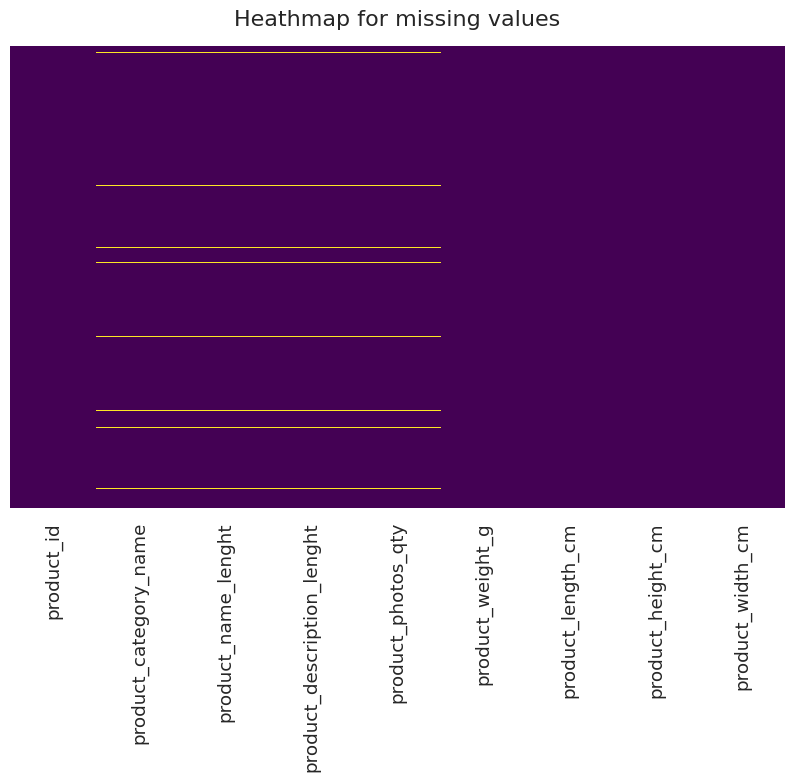


Analyzing columns: product_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 32951, 'most_frequent': '00066f42aeeb9f3007548bb9d3f33c38'}
The column product_id has more than 20 unique values.

Analyzing columns: product_category_name
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(610), 'unique_values': 73, 'most_frequent': 'cama_mesa_banho'}
The column product_category_name has more than 20 unique values.

Analyzing columns: product_name_lenght
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(610), 'mean': np.float64(48.47694876472589), 'std_dev': 10.245740725237479, 'min': 5.0, 'max': 76.0, 'outliers': np.int64(2322)}


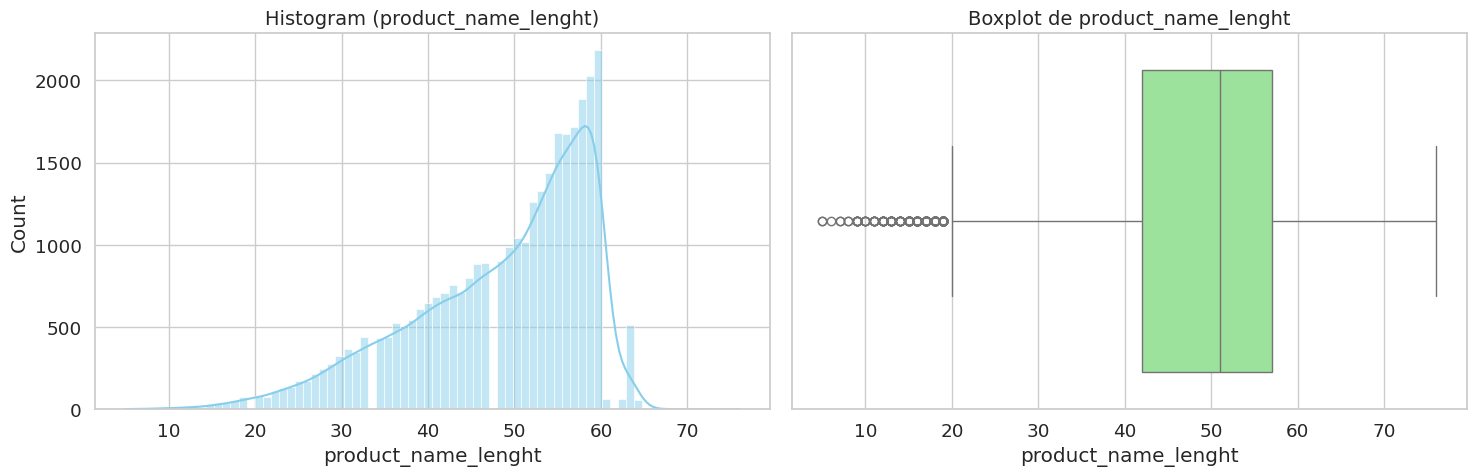


Analyzing columns: product_description_lenght
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(610), 'mean': np.float64(771.4952846232337), 'std_dev': 635.1152246349546, 'min': 4.0, 'max': 3992.0, 'outliers': np.int64(3212)}


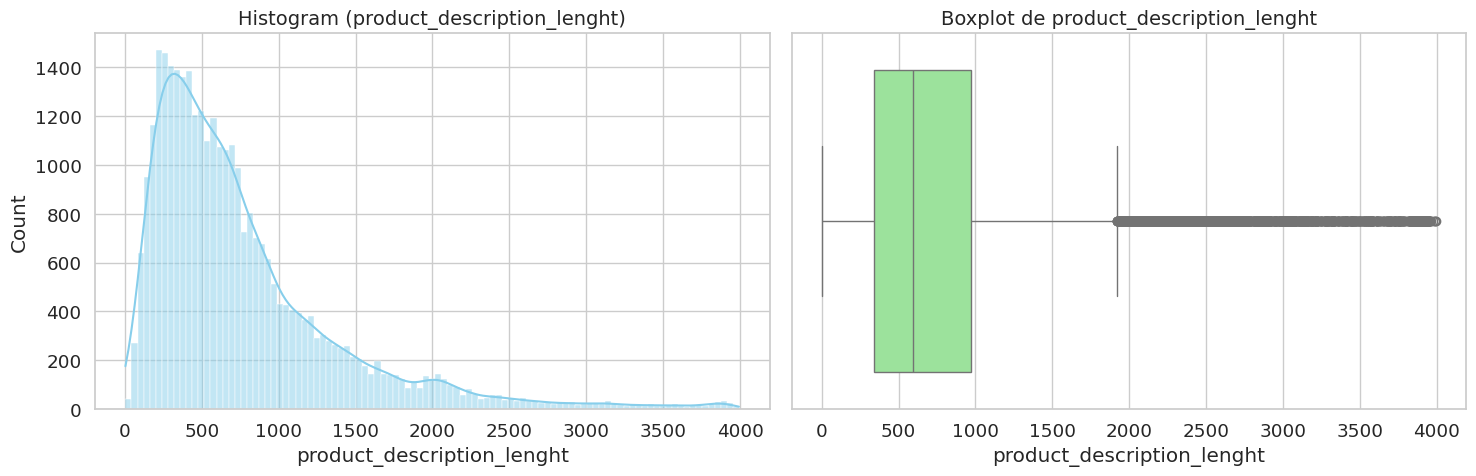


Analyzing columns: product_photos_qty
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(610), 'mean': np.float64(2.1889861166939797), 'std_dev': 1.7367656379315015, 'min': 1.0, 'max': 20.0, 'outliers': np.int64(849)}


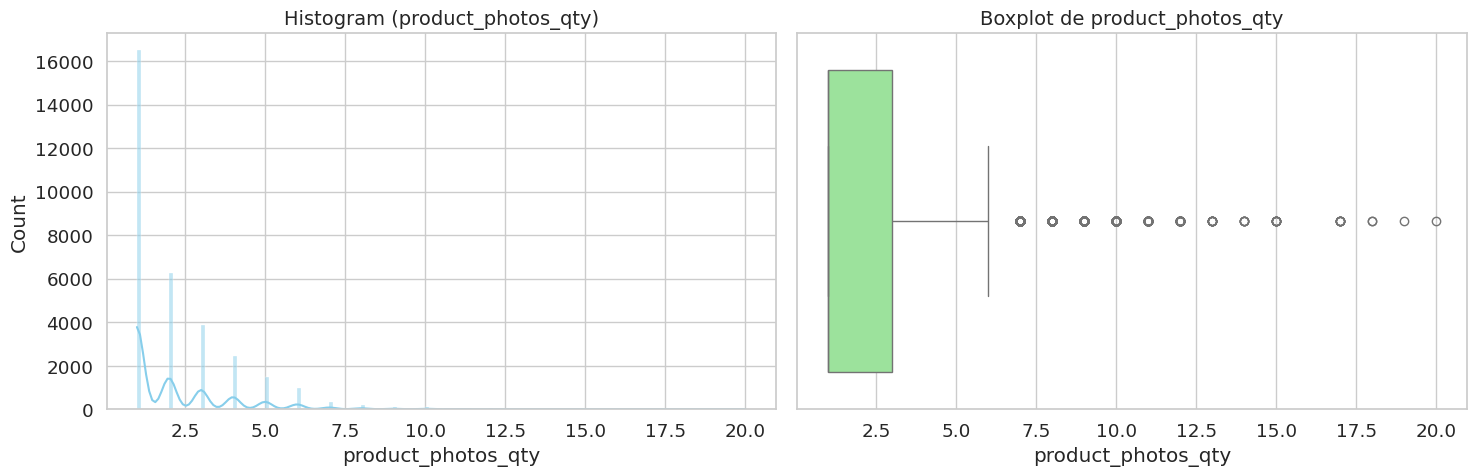


Analyzing columns: product_weight_g
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(2), 'mean': np.float64(2276.4724877841513), 'std_dev': 4282.038730977634, 'min': 0.0, 'max': 40425.0, 'outliers': np.int64(3279)}


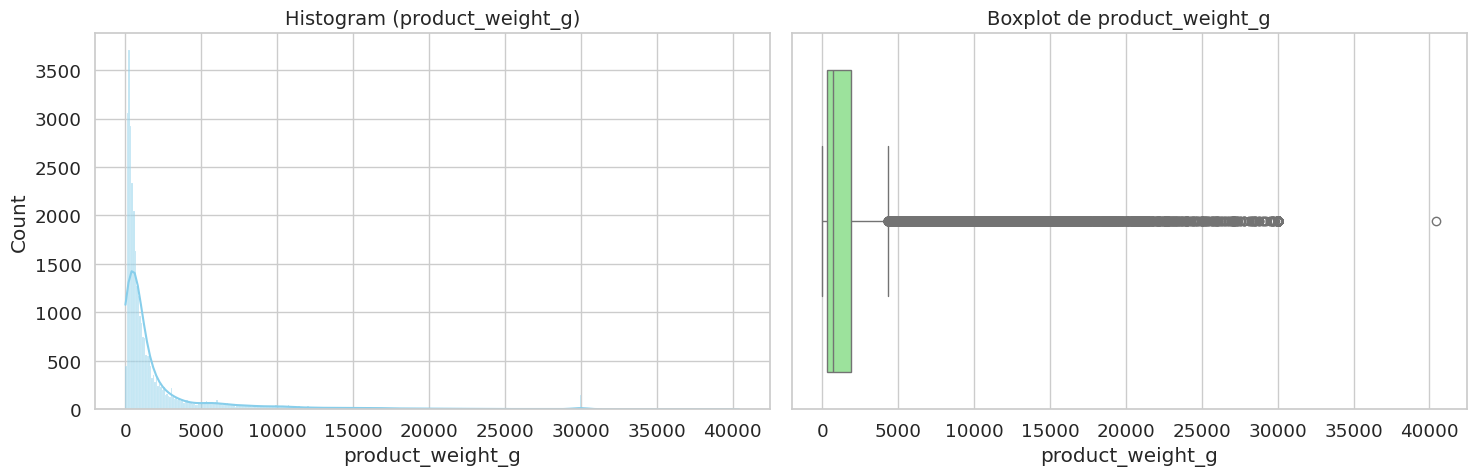


Analyzing columns: product_length_cm
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(2), 'mean': np.float64(30.81507784758263), 'std_dev': 16.91445805406699, 'min': 7.0, 'max': 105.0, 'outliers': np.int64(1694)}


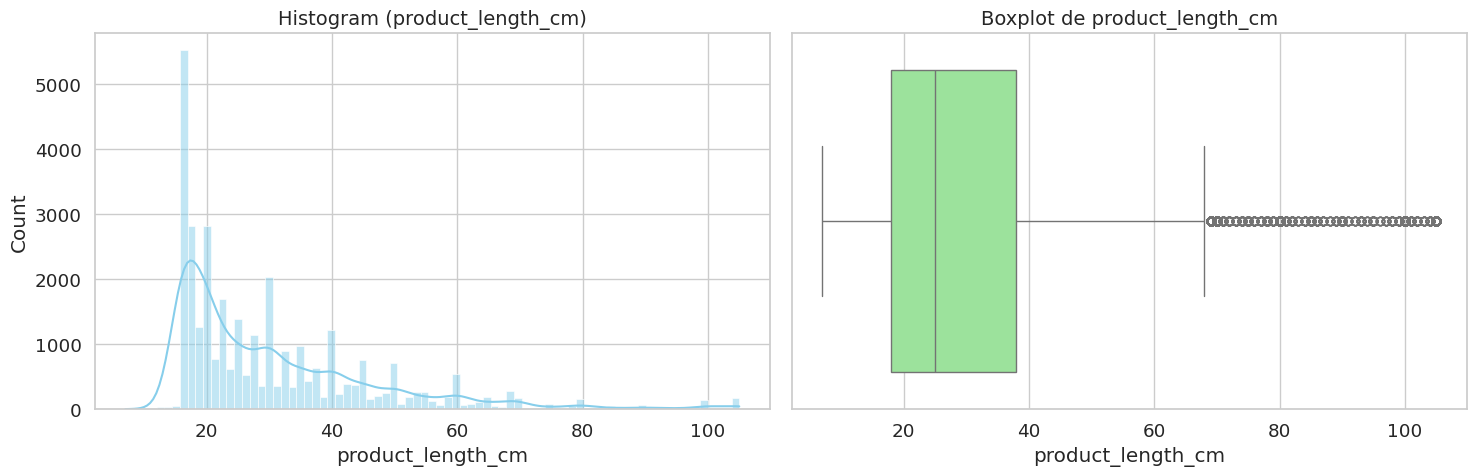


Analyzing columns: product_height_cm
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(2), 'mean': np.float64(16.937661234028347), 'std_dev': 13.637554061749832, 'min': 2.0, 'max': 105.0, 'outliers': np.int64(2956)}


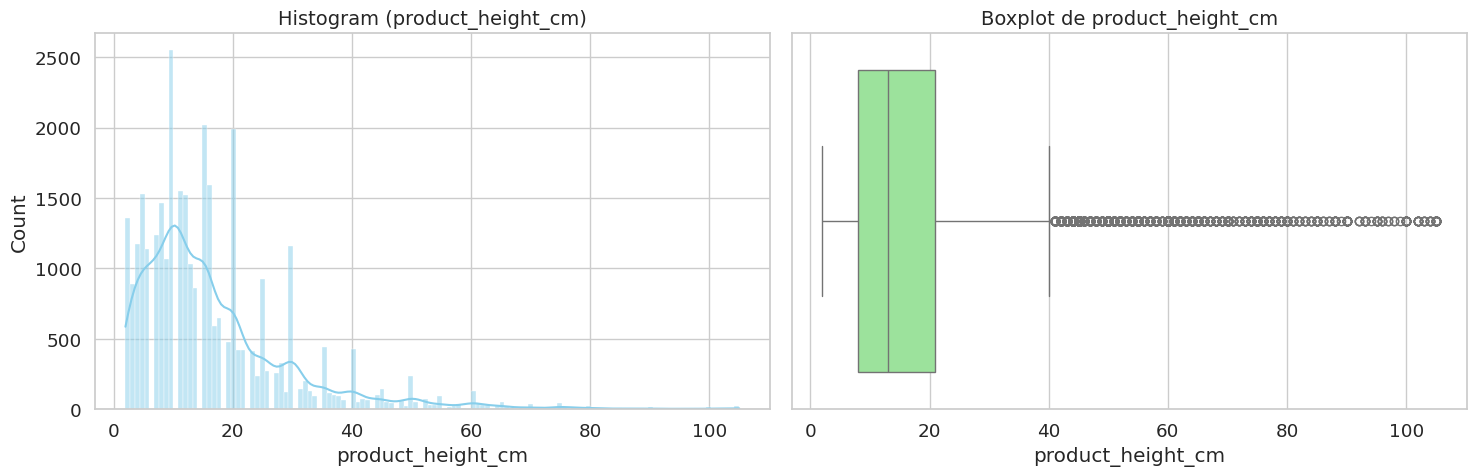


Analyzing columns: product_width_cm
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(2), 'mean': np.float64(23.196728277034204), 'std_dev': 12.07904745322808, 'min': 6.0, 'max': 118.0, 'outliers': np.int64(1616)}


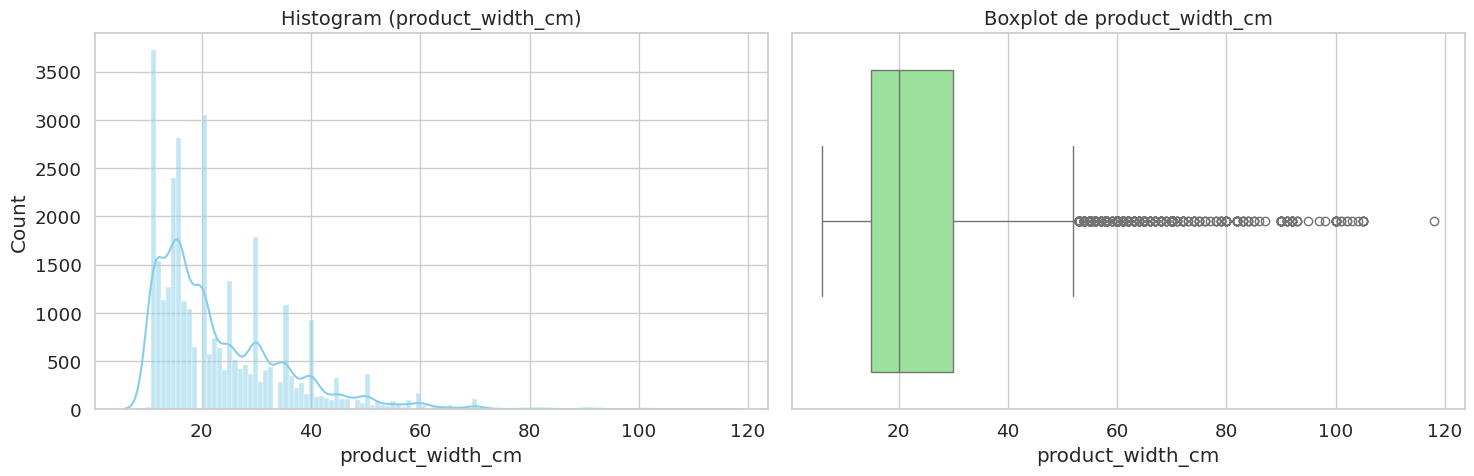

{'product_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 32951,
  'most_frequent': '00066f42aeeb9f3007548bb9d3f33c38'},
 'product_category_name': {'type': 'categorical',
  'missing_values': np.int64(610),
  'unique_values': 73,
  'most_frequent': 'cama_mesa_banho'},
 'product_name_lenght': {'type': 'numeric',
  'missing_values': np.int64(610),
  'mean': np.float64(48.47694876472589),
  'std_dev': 10.245740725237479,
  'min': 5.0,
  'max': 76.0,
  'outliers': np.int64(2322)},
 'product_description_lenght': {'type': 'numeric',
  'missing_values': np.int64(610),
  'mean': np.float64(771.4952846232337),
  'std_dev': 635.1152246349546,
  'min': 4.0,
  'max': 3992.0,
  'outliers': np.int64(3212)},
 'product_photos_qty': {'type': 'numeric',
  'missing_values': np.int64(610),
  'mean': np.float64(2.1889861166939797),
  'std_dev': 1.7367656379315015,
  'min': 1.0,
  'max': 20.0,
  'outliers': np.int64(849)},
 'product_weight_g': {'type': 'numeric',
  'missing_v

In [166]:
generate_data_profile (products)

**Checking missing values:**

In [167]:
check_missing_values (products)

,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


**Uniqueness is 100%:**

In [168]:
print (check_duplicates (products, 'product_id'))

(0, Empty DataFrame
Columns: [product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm]
Index: [])


**There is a considerable amount of missing values, without any consistent pattern or correlation between columns that could justify it; it appears to be simply random incompleteness:**

In [169]:
n_v_p = pd.DataFrame(check_missing_values(products), columns=['Missing Values']) #Evaluating where is the nullvalues
missing_v = n_v_p ['Missing Values'].sum() #Sumarizing it

In [170]:
check_missing_values (products)

,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


In [171]:
products.info() #Catching rangeindex count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


**The proportion is 2448/32951, which means that 7.429% of columns are missing:**

In [172]:
print (f"Missing date percentage : {(missing_v/32951)*100 }")

Missing date percentage : 7.4292130739583015


In [173]:
products_null = products[products[['product_category_name',
                                   'product_name_lenght',
                                   'product_description_lenght',
                                   'product_photos_qty']].isnull().any(axis=1)]

products_null = products_null[['product_category_name',
                               'product_name_lenght',
                               'product_description_lenght',
                               'product_photos_qty']]

print (f'Missing values:    {len(products_null)}')

Missing values:    610


**The largest count (610) corresponds to the missing values, indicating an incompleteness of approximately 610 rows. Proportionally, these missing values represent 1.85% of the total rows, which is unlikely to significantly impact our operations. Therefore, the chosen approach will be to remove these rows where missing values are prevalent.**

In [174]:
print (f"Mutual incomplete rows: {(610/32951) * 100}")

Mutual incomplete rows: 1.8512336499650999


**Creating consumable dataframe:**

In [175]:
products_t = products.drop (products_null.index)

**Checking:**

In [176]:
check_missing_values (products_t)

,0
product_id,0
product_category_name,0
product_name_lenght,0
product_description_lenght,0
product_photos_qty,0
product_weight_g,1
product_length_cm,1
product_height_cm,1
product_width_cm,1


**Filling the remaining null values:**

In [177]:
imputer = SimpleImputer(strategy='mean')  # Use mean imputation for numeric columns
numeric_cols = products_t.select_dtypes(include=['int64', 'float64']).columns
products_t[numeric_cols] = imputer.fit_transform(products_t[numeric_cols])

**Checking data type consistence:**

In [178]:
data_type_consistency (products_t)

,Data Type
product_id,object
product_category_name,object
product_name_lenght,float64
product_description_lenght,float64
product_photos_qty,float64
product_weight_g,float64
product_length_cm,float64
product_height_cm,float64
product_width_cm,float64


**Setting product_name as UUID:**

In [179]:
data_type_to_uuid (products_t, 'product_id')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef0-4dbc-ff45-41ed-26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa07113-9cb1-6b67-ca9e-5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec-8810-374e-d1b6-5e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcf-e190-66a9-32b7-673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de-2744-4484-9c21-9cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a9-92cc-da64-6f2d-34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d8-8321-d0fd-4412-a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041-fa95-92d9-d9ef-6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703-fc07-06a2-2e26-4b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


**Setting product_categorical_name to Categorical:**

In [180]:
data_type_to_categorical (products_t, 'product_category_name')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef0-4dbc-ff45-41ed-26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa07113-9cb1-6b67-ca9e-5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec-8810-374e-d1b6-5e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcf-e190-66a9-32b7-673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de-2744-4484-9c21-9cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a9-92cc-da64-6f2d-34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d8-8321-d0fd-4412-a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041-fa95-92d9-d9ef-6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703-fc07-06a2-2e26-4b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


**Setting product_name_lenght and product_name_lenght to INT:**

In [181]:
data_type_to_int (products_t, 'product_name_lenght', 8)
data_type_to_int (products_t, 'product_description_lenght', 16)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef0-4dbc-ff45-41ed-26657ea517e5,perfumaria,40,287,1.0,225.0,16.0,10.0,14.0
1,3aa07113-9cb1-6b67-ca9e-5dea641aaa2f,artes,44,276,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec-8810-374e-d1b6-5e291975717f,esporte_lazer,46,250,1.0,154.0,18.0,9.0,15.0
3,cef67bcf-e190-66a9-32b7-673e239eb23d,bebes,27,261,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de-2744-4484-9c21-9cff195d0b71,utilidades_domesticas,37,402,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a9-92cc-da64-6f2d-34e418fff5a0,moveis_decoracao,45,67,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d8-8321-d0fd-4412-a93c974510e6,construcao_ferramentas_iluminacao,41,971,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041-fa95-92d9-d9ef-6cfe62a71f8c,cama_mesa_banho,50,799,1.0,1400.0,27.0,7.0,27.0
32949,83808703-fc07-06a2-2e26-4b9d75f04a2e,informatica_acessorios,60,156,2.0,700.0,31.0,13.0,20.0


**Setting product_photos_qty as INT:**

In [182]:
data_type_to_int (products_t, 'product_photos_qty', 8)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef0-4dbc-ff45-41ed-26657ea517e5,perfumaria,40,287,1,225.0,16.0,10.0,14.0
1,3aa07113-9cb1-6b67-ca9e-5dea641aaa2f,artes,44,276,1,1000.0,30.0,18.0,20.0
2,96bd76ec-8810-374e-d1b6-5e291975717f,esporte_lazer,46,250,1,154.0,18.0,9.0,15.0
3,cef67bcf-e190-66a9-32b7-673e239eb23d,bebes,27,261,1,371.0,26.0,4.0,26.0
4,9dc1a7de-2744-4484-9c21-9cff195d0b71,utilidades_domesticas,37,402,4,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a9-92cc-da64-6f2d-34e418fff5a0,moveis_decoracao,45,67,2,12300.0,40.0,40.0,40.0
32947,bf4538d8-8321-d0fd-4412-a93c974510e6,construcao_ferramentas_iluminacao,41,971,1,1700.0,16.0,19.0,16.0
32948,9a7c6041-fa95-92d9-d9ef-6cfe62a71f8c,cama_mesa_banho,50,799,1,1400.0,27.0,7.0,27.0
32949,83808703-fc07-06a2-2e26-4b9d75f04a2e,informatica_acessorios,60,156,2,700.0,31.0,13.0,20.0


*While a categorical representation is also a possibility, I chose to maintain the data type as INT. This decision is based on the requirement that it must satisfy all potential future modeling needs without deprecating the data type consistence and structure*

**Checking:**

In [183]:
data_type_consistency (products_t)

,Data Type
product_id,object
product_category_name,category
product_name_lenght,int8
product_description_lenght,int16
product_photos_qty,int8
product_weight_g,float64
product_length_cm,float64
product_height_cm,float64
product_width_cm,float64


**Saving the transformed dataframe:**

In [184]:
consumeable_dataframes.append(products_t)

## Payments

In [185]:
payments = dataframes['olist_order_payments_dataset']

**Data profile:**

Analyzing values...


<Figure size 1200x600 with 0 Axes>

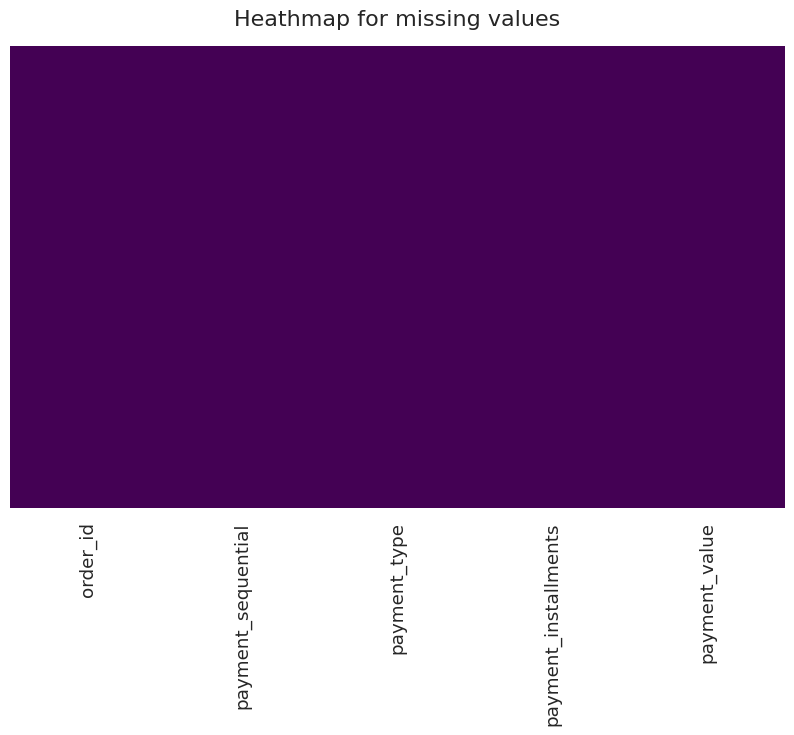


Analyzing columns: order_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 99440, 'most_frequent': 'fa65dad1b0e818e3ccc5cb0e39231352'}
The column order_id has more than 20 unique values.

Analyzing columns: payment_sequential
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(1.0926785129853878), 'std_dev': 0.7065837791945014, 'min': 1, 'max': 29, 'outliers': np.int64(4526)}


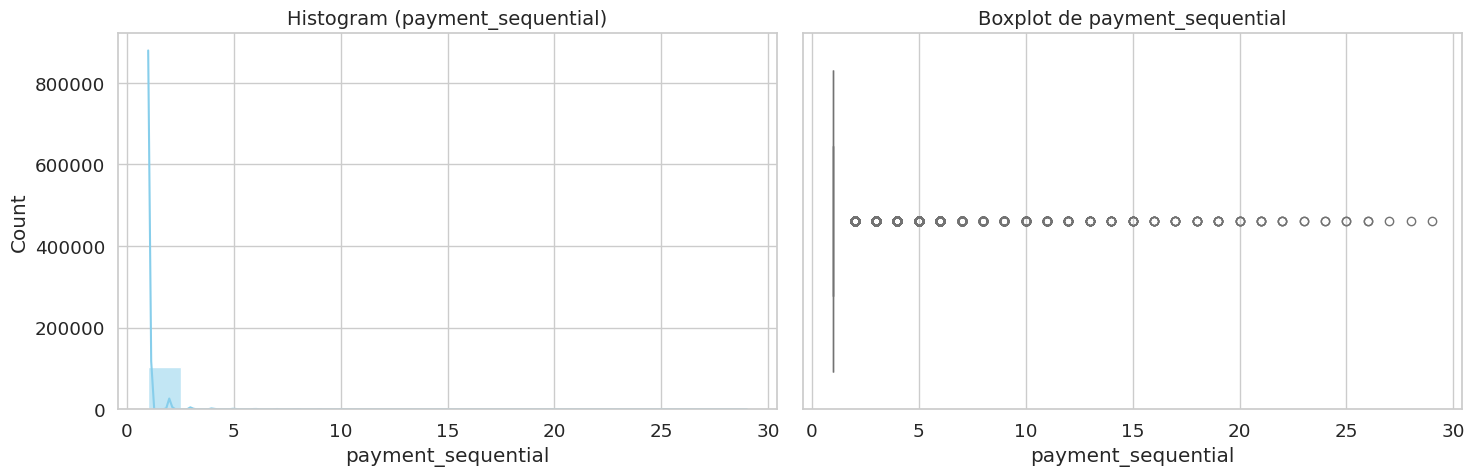


Analyzing columns: payment_type
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 5, 'most_frequent': 'credit_card'}


<ipython-input-121-f67c98861711>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df[column].value_counts().index, palette='pastel')


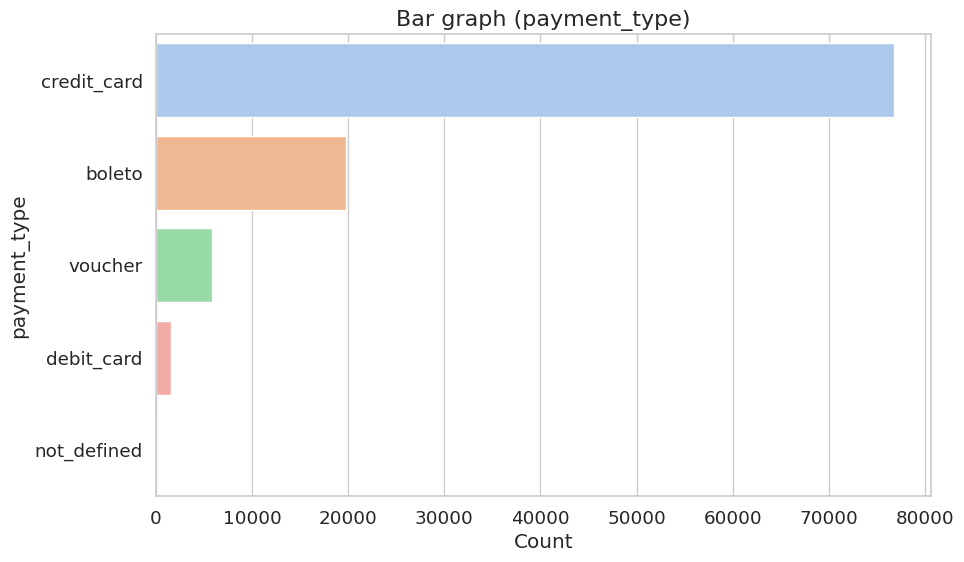


Analyzing columns: payment_installments
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(2.853348863176944), 'std_dev': 2.6870506738557367, 'min': 0, 'max': 24, 'outliers': np.int64(343)}


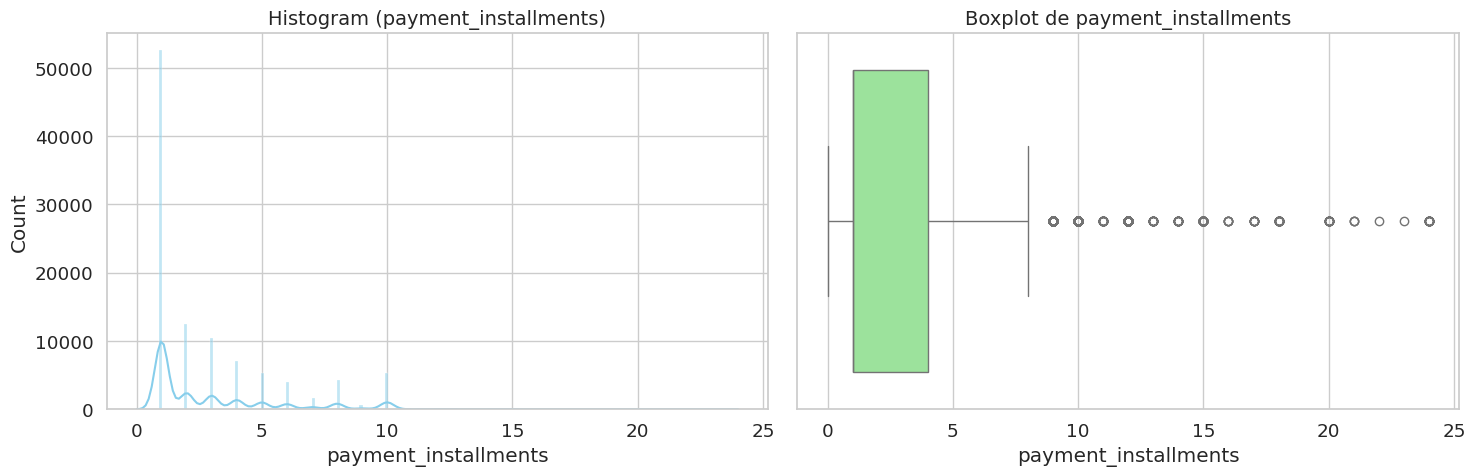


Analyzing columns: payment_value
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(154.10038041699553), 'std_dev': 217.49406386472577, 'min': 0.0, 'max': 13664.08, 'outliers': np.int64(10390)}


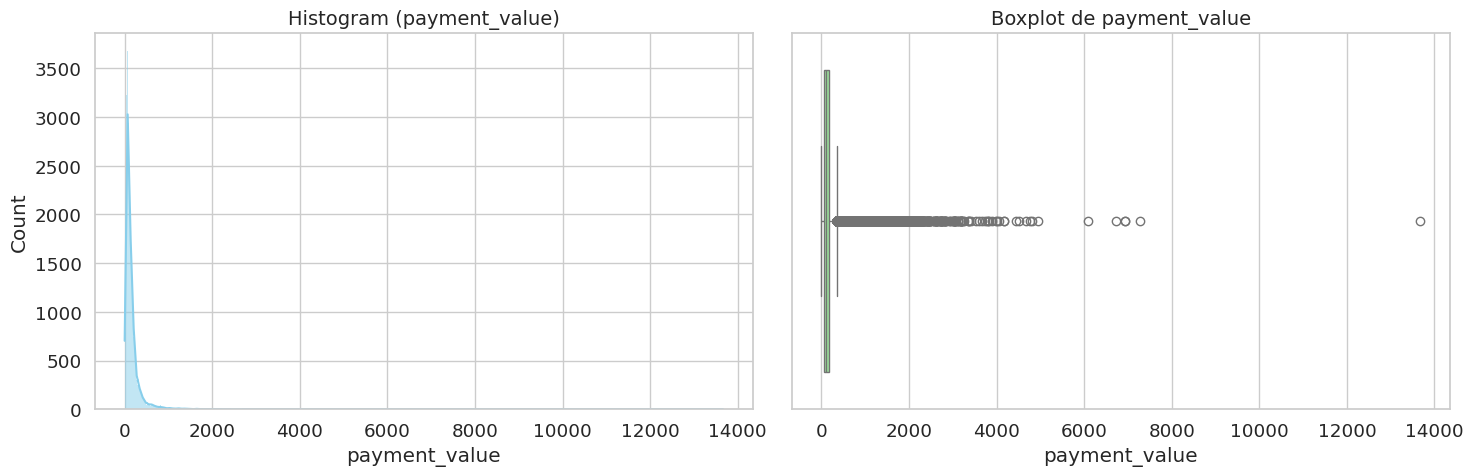

{'order_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 99440,
  'most_frequent': 'fa65dad1b0e818e3ccc5cb0e39231352'},
 'payment_sequential': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(1.0926785129853878),
  'std_dev': 0.7065837791945014,
  'min': 1,
  'max': 29,
  'outliers': np.int64(4526)},
 'payment_type': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 5,
  'most_frequent': 'credit_card'},
 'payment_installments': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(2.853348863176944),
  'std_dev': 2.6870506738557367,
  'min': 0,
  'max': 24,
  'outliers': np.int64(343)},
 'payment_value': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(154.10038041699553),
  'std_dev': 217.49406386472577,
  'min': 0.0,
  'max': 13664.08,
  'outliers': np.int64(10390)}}

In [186]:
generate_data_profile (payments)

*It is readily apparent that credit card is the most frequently used payment method.*

**Complitude 100%:**

In [187]:
check_missing_values (payments)

,0
order_id,0
payment_sequential,0
payment_type,0
payment_installments,0
payment_value,0


In [188]:
check_duplicates(payments, 'order_id')

(7407,
                                 order_id  payment_sequential payment_type  \
 25      5cfd514482e22bc992e7693f0e3e8df7                   2      voucher   
 35      b2bb080b6bc860118a246fd9b6fad6da                   1  credit_card   
 75      3689194c14ad4e2e7361ebd1df0e77b0                   2      voucher   
 84      723e462ce1ee50e024887c0b403130f3                   1  credit_card   
 102     21b8b46679ea6482cbf911d960490048                   2      voucher   
 ...                                  ...                 ...          ...   
 103778  fd86c80924b4be8fb7f58c4ecc680dae                   1  credit_card   
 103817  6d4616de4341417e17978fe57aec1c46                   1  credit_card   
 103860  31bc09fdbd701a7a4f9b55b5955b8687                   6      voucher   
 103869  c9b01bef18eb84888f0fd071b8413b38                   1  credit_card   
 103874  d41f1036712e18ee525939d08b7a1c98                   1  credit_card   
 
         payment_installments  payment_value  
 25     

**A pattern of duplicate Order_Id values exists, but this is expected because each payment made for a single order generates a new record in the data asset under the same Order_Id. Therefore, these duplicates should not be removed:**

In [189]:
payments[payments['order_id'] == 'd41f1036712e18ee525939d08b7a1c98'] #Example

,order_id,payment_sequential,payment_type,payment_installments,payment_value
6424,d41f1036712e18ee525939d08b7a1c98,6,voucher,1,17.14
34091,d41f1036712e18ee525939d08b7a1c98,2,voucher,1,17.14
39382,d41f1036712e18ee525939d08b7a1c98,5,voucher,1,17.14
47661,d41f1036712e18ee525939d08b7a1c98,3,voucher,1,17.14
73531,d41f1036712e18ee525939d08b7a1c98,4,voucher,1,17.14
103874,d41f1036712e18ee525939d08b7a1c98,1,credit_card,1,3.57


**Checking data profile consistence:**

In [190]:
data_type_consistency (payments)

,Data Type
order_id,object
payment_sequential,int64
payment_type,object
payment_installments,int64
payment_value,float64


**Creating consumeable dataframe:**

In [191]:
payments_t = payments.copy()

**Setting order_id id as UUID:**

In [192]:
data_type_to_uuid (payments_t, 'order_id')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226-f3fe-1789-b1e8-b2acac839d17,1,credit_card,8,99.33
1,a9810da8-2917-af2d-9aef-d1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e-9339-6b6f-a0d3-dd708e76c1bd,1,credit_card,1,65.71
3,ba789979-21bb-cdc1-373b-b41e913ab953,1,credit_card,8,107.78
4,42fdf880-ba16-b47b-5925-1dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037a-d977-40d5-63a1-78ecc7a2075c,1,boleto,1,363.31
103882,7b905861-d7c8-2589-1d63-47454ea7863f,1,credit_card,2,96.80
103883,32609bbb-3dd6-9b3c-066a-6860554a77bf,1,credit_card,1,47.77
103884,b8b61059-626e-fa99-6a60-be9bb9320e10,1,credit_card,5,369.54


**Setting payment_sequential as INT8:**

In [193]:
data_type_to_int (payments_t, 'payment_sequential', 8)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226-f3fe-1789-b1e8-b2acac839d17,1,credit_card,8,99.33
1,a9810da8-2917-af2d-9aef-d1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e-9339-6b6f-a0d3-dd708e76c1bd,1,credit_card,1,65.71
3,ba789979-21bb-cdc1-373b-b41e913ab953,1,credit_card,8,107.78
4,42fdf880-ba16-b47b-5925-1dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037a-d977-40d5-63a1-78ecc7a2075c,1,boleto,1,363.31
103882,7b905861-d7c8-2589-1d63-47454ea7863f,1,credit_card,2,96.80
103883,32609bbb-3dd6-9b3c-066a-6860554a77bf,1,credit_card,1,47.77
103884,b8b61059-626e-fa99-6a60-be9bb9320e10,1,credit_card,5,369.54


**Setting payment_type as categorical:**

In [194]:
data_type_to_categorical (payments_t, 'payment_type')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226-f3fe-1789-b1e8-b2acac839d17,1,credit_card,8,99.33
1,a9810da8-2917-af2d-9aef-d1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e-9339-6b6f-a0d3-dd708e76c1bd,1,credit_card,1,65.71
3,ba789979-21bb-cdc1-373b-b41e913ab953,1,credit_card,8,107.78
4,42fdf880-ba16-b47b-5925-1dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037a-d977-40d5-63a1-78ecc7a2075c,1,boleto,1,363.31
103882,7b905861-d7c8-2589-1d63-47454ea7863f,1,credit_card,2,96.80
103883,32609bbb-3dd6-9b3c-066a-6860554a77bf,1,credit_card,1,47.77
103884,b8b61059-626e-fa99-6a60-be9bb9320e10,1,credit_card,5,369.54


**Setting payment_installments as INT8:**

In [195]:
data_type_to_int (payments_t, 'payment_installments', 8)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226-f3fe-1789-b1e8-b2acac839d17,1,credit_card,8,99.33
1,a9810da8-2917-af2d-9aef-d1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e-9339-6b6f-a0d3-dd708e76c1bd,1,credit_card,1,65.71
3,ba789979-21bb-cdc1-373b-b41e913ab953,1,credit_card,8,107.78
4,42fdf880-ba16-b47b-5925-1dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037a-d977-40d5-63a1-78ecc7a2075c,1,boleto,1,363.31
103882,7b905861-d7c8-2589-1d63-47454ea7863f,1,credit_card,2,96.80
103883,32609bbb-3dd6-9b3c-066a-6860554a77bf,1,credit_card,1,47.77
103884,b8b61059-626e-fa99-6a60-be9bb9320e10,1,credit_card,5,369.54


**Checking:**

In [196]:
data_type_consistency (payments_t)

,Data Type
order_id,object
payment_sequential,int8
payment_type,category
payment_installments,int8
payment_value,float64


**Saving the transformed dataframe:**

In [197]:
consumeable_dataframes.append(payments_t)

**

## Reviews

In [198]:
reviews = dataframes['olist_order_reviews_dataset']

In [199]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


**Data profile:**

Analyzing values...


<Figure size 1200x600 with 0 Axes>

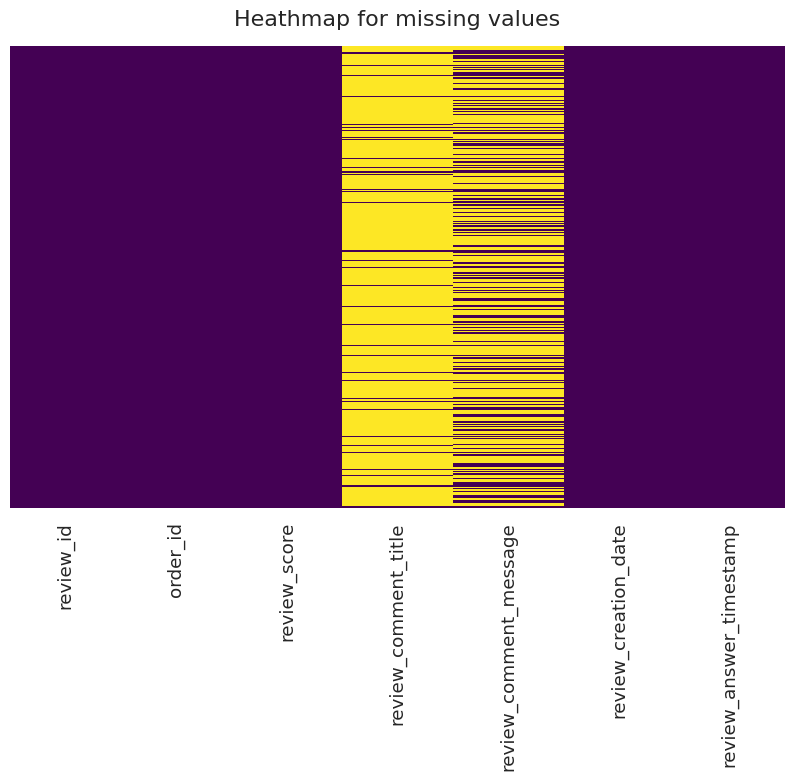


Analyzing columns: review_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 98410, 'most_frequent': '08528f70f579f0c830189efc523d2182'}
The column review_id has more than 20 unique values.

Analyzing columns: order_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 98673, 'most_frequent': '03c939fd7fd3b38f8485a0f95798f1f6'}
The column order_id has more than 20 unique values.

Analyzing columns: review_score
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(4.08642062404257), 'std_dev': 1.3475791311148884, 'min': 1, 'max': 5, 'outliers': np.int64(0)}


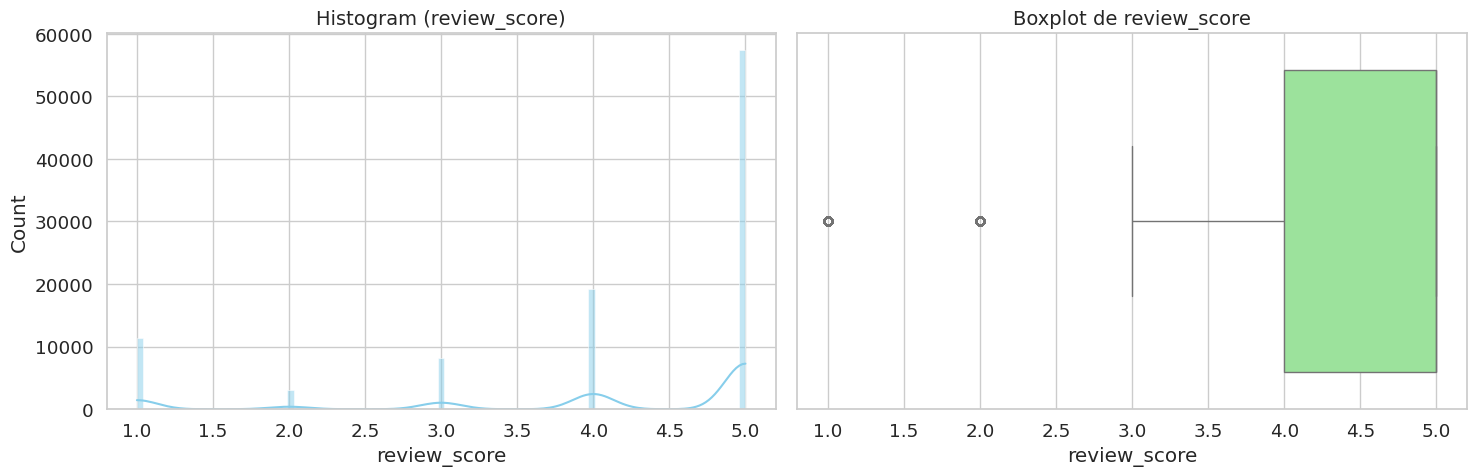


Analyzing columns: review_comment_title
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(87656), 'unique_values': 4527, 'most_frequent': 'Recomendo'}
The column review_comment_title has more than 20 unique values.

Analyzing columns: review_comment_message
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(58247), 'unique_values': 36159, 'most_frequent': 'Muito bom'}
The column review_comment_message has more than 20 unique values.

Analyzing columns: review_creation_date
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 636, 'most_frequent': '2017-12-19 00:00:00'}
The column review_creation_date has more than 20 unique values.

Analyzing columns: review_answer_timestamp
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 98248, 'mos

{'review_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 98410,
  'most_frequent': '08528f70f579f0c830189efc523d2182'},
 'order_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 98673,
  'most_frequent': '03c939fd7fd3b38f8485a0f95798f1f6'},
 'review_score': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(4.08642062404257),
  'std_dev': 1.3475791311148884,
  'min': 1,
  'max': 5,
  'outliers': np.int64(0)},
 'review_comment_title': {'type': 'categorical',
  'missing_values': np.int64(87656),
  'unique_values': 4527,
  'most_frequent': 'Recomendo'},
 'review_comment_message': {'type': 'categorical',
  'missing_values': np.int64(58247),
  'unique_values': 36159,
  'most_frequent': 'Muito bom'},
 'review_creation_date': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 636,
  'most_frequent': '2017-12-19 00:00:00'},
 'review_answer_timestamp': {'type': 'categorical',
  'missi

In [200]:
generate_data_profile (reviews)

**A significant number of missing values exist because not every client submits a comment, title, or product evaluation:**

In [201]:
check_missing_values (reviews)

,0
review_id,0
order_id,0
review_score,0
review_comment_title,87656
review_comment_message,58247
review_creation_date,0
review_answer_timestamp,0


**Although there is a significant amount of missing data and comments, this is to be expected as not all users provide comments with their ratings. However, given the near-complete (approximately 100%) presence of
review_score values, the approach will be to simply populate any missing comment fields with an empty string:**

**Creating consumeable dataframe:**

In [202]:
reviews_t = reviews.copy()

**Filling NA with empty string:**

In [203]:
reviews_t.fillna ('', inplace = True)

**Checking duplicates:**

In [204]:
check_duplicates (reviews_t, 'review_id')
check_duplicates (reviews_t, 'order_id')


(1098,
                               review_id                          order_id  \
 30     540e7bbb2d06cfb7f85f3a88ba7ac97f  cf73e2cb1f4a9480ed70c154da3d954a   
 344    a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
 498    505a882ba08a689682a4afc6eb4e5965  1c308eca3f339414a92e518e2a2e5ee9   
 764    c5976a5a98e854fb23d7e03c6754ae60  2002ea16e75277eaa0b5d78632048540   
 778    62c7722239b976d943ec0d430cfe890e  1d297b4800ed1a3c5b0944d84c01ee99   
 ...                                 ...                               ...   
 98989  dfb3db02188d809d5cd199496b6da87e  c0db7d31ace61fc360a3eaa34dd3457c   
 99108  2c6c08892b83ba4c1be33037c2842294  42ae1967f68c90bb325783ac55d761ce   
 99164  2afe63a67dfd99b3038f568fb47ee761  c5334d330e36d2a810a7a13c72e135ee   
 99178  44d1e9165ec54b1d89d33594856af859  a7dbcf5043158d6fa72859eead2f3d10   
 99199  40743b46a0ee86375cedb95e82b78d75  3e93213bb8fdda91186b4018b2fe0030   
 
        review_score review_comment_title  \
 30       

**The duplication of reviews across different orders lacks a clear rationale with the providen information. Given the consistency of timestamps and comments, which indicate that the reviews were indeed made for the same product but under different order IDs, duplicates will be removed based on the review ID :**

In [205]:
reviews_t.drop_duplicates(subset='review_id', keep='first', inplace=True)

In [206]:
check_duplicates (reviews_t, 'review_id')
check_duplicates (reviews_t, 'order_id')

(486,
                               review_id                          order_id  \
 30     540e7bbb2d06cfb7f85f3a88ba7ac97f  cf73e2cb1f4a9480ed70c154da3d954a   
 344    a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
 498    505a882ba08a689682a4afc6eb4e5965  1c308eca3f339414a92e518e2a2e5ee9   
 764    c5976a5a98e854fb23d7e03c6754ae60  2002ea16e75277eaa0b5d78632048540   
 1028   afd9b3d196f0acd81d79d8ccd79c2430  5040757d4e06a4be96d3827b860b4e7c   
 ...                                 ...                               ...   
 97369  d4d5f3dcd2130a28d547b0ec78b2a707  64f2e9aa85911b6a48e3d11ef05b73c7   
 98048  41f9e1785dd8ea3b6777220901df3c8e  bee4fbc438d2d48527e812cb6a1c8166   
 98495  77f1a000f9f3d97382cf32b6b3bb6e7a  2739713764165279791b394484947e2d   
 98654  e28cc2a1bf48c11dbcc990894356bd82  1de86d094f7dd41cca13d246d3b7fd07   
 99199  40743b46a0ee86375cedb95e82b78d75  3e93213bb8fdda91186b4018b2fe0030   
 
        review_score review_comment_title review_comment

**Checking data type consistence:**

In [207]:
data_type_consistency (reviews_t)

,Data Type
review_id,object
order_id,object
review_score,int64
review_comment_title,object
review_comment_message,object
review_creation_date,object
review_answer_timestamp,object


**Setting review_id, order_id as UUID:**

In [208]:
data_type_to_uuid (reviews_t, 'review_id')
data_type_to_uuid (reviews_t, 'order_id')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc24061-10b9-2639-3aa5-6f80a40eba40,73fc7af8-7114-b397-12e6-da79b0a377eb,4,,,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a1-1e56-f04c-1ad4-69d5645fdfde,a548910a-1c61-4779-6b98-fdf73dbeba33,5,,,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce550-0dc1-d8e0-20d8-d1322874b6f0,f9e4b658-b201-a9f2-ecde-cbb34bed034b,5,,,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393-e7b3-2834-bb78-9ff8bb30750e,658677c9-7b38-5a9b-e170-737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c-7fe1-938f-181b-ec41a392bdeb,8e6bfb81-e283-fa7e-4f11-123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12d-d733-e5fa-530c-fd4bbf39d7c9,2a8c23fe-e101-d4d5-662f-a670396eb8da,5,,,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127-253a-9592-a73b-e9bdfdf4ed7a,22ec9f06-69f7-84db-00fa-86d035cf8602,5,,,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c8-9b15-10c4-cd3d-0649fd302472,55d40047-4436-8f55-71d1-f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d8-4d72-fe4e-3376-17733eb85149,7725825d-039f-c1f0-ceb7-635e3f7d9206,4,,,2018-07-01 00:00:00,2018-07-02 12:59:13


**Setting review_comment_title and review_comment_message as STR:**

In [209]:
data_type_to_string (reviews_t, 'review_comment_title')
data_type_to_string (reviews_t, 'review_comment_message')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc24061-10b9-2639-3aa5-6f80a40eba40,73fc7af8-7114-b397-12e6-da79b0a377eb,4,,,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a1-1e56-f04c-1ad4-69d5645fdfde,a548910a-1c61-4779-6b98-fdf73dbeba33,5,,,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce550-0dc1-d8e0-20d8-d1322874b6f0,f9e4b658-b201-a9f2-ecde-cbb34bed034b,5,,,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393-e7b3-2834-bb78-9ff8bb30750e,658677c9-7b38-5a9b-e170-737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c-7fe1-938f-181b-ec41a392bdeb,8e6bfb81-e283-fa7e-4f11-123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12d-d733-e5fa-530c-fd4bbf39d7c9,2a8c23fe-e101-d4d5-662f-a670396eb8da,5,,,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127-253a-9592-a73b-e9bdfdf4ed7a,22ec9f06-69f7-84db-00fa-86d035cf8602,5,,,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c8-9b15-10c4-cd3d-0649fd302472,55d40047-4436-8f55-71d1-f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d8-4d72-fe4e-3376-17733eb85149,7725825d-039f-c1f0-ceb7-635e3f7d9206,4,,,2018-07-01 00:00:00,2018-07-02 12:59:13


**Setting review_creating_date and review_answer_timestamp to datetime:**

In [210]:
data_type_to_datetime (reviews_t, 'review_creation_date')
data_type_to_datetime (reviews_t, 'review_answer_timestamp')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc24061-10b9-2639-3aa5-6f80a40eba40,73fc7af8-7114-b397-12e6-da79b0a377eb,4,,,2018-01-18,2018-01-18 21:46:59
1,80e641a1-1e56-f04c-1ad4-69d5645fdfde,a548910a-1c61-4779-6b98-fdf73dbeba33,5,,,2018-03-10,2018-03-11 03:05:13
2,228ce550-0dc1-d8e0-20d8-d1322874b6f0,f9e4b658-b201-a9f2-ecde-cbb34bed034b,5,,,2018-02-17,2018-02-18 14:36:24
3,e64fb393-e7b3-2834-bb78-9ff8bb30750e,658677c9-7b38-5a9b-e170-737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c-7fe1-938f-181b-ec41a392bdeb,8e6bfb81-e283-fa7e-4f11-123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12d-d733-e5fa-530c-fd4bbf39d7c9,2a8c23fe-e101-d4d5-662f-a670396eb8da,5,,,2018-07-07,2018-07-14 17:18:30
99220,f3897127-253a-9592-a73b-e9bdfdf4ed7a,22ec9f06-69f7-84db-00fa-86d035cf8602,5,,,2017-12-09,2017-12-11 20:06:42
99221,b3de70c8-9b15-10c4-cd3d-0649fd302472,55d40047-4436-8f55-71d1-f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43
99222,1adeb9d8-4d72-fe4e-3376-17733eb85149,7725825d-039f-c1f0-ceb7-635e3f7d9206,4,,,2018-07-01,2018-07-02 12:59:13


**Setting review_score to INT8:**

In [211]:
data_type_to_int (reviews_t, 'review_score', 8)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc24061-10b9-2639-3aa5-6f80a40eba40,73fc7af8-7114-b397-12e6-da79b0a377eb,4,,,2018-01-18,2018-01-18 21:46:59
1,80e641a1-1e56-f04c-1ad4-69d5645fdfde,a548910a-1c61-4779-6b98-fdf73dbeba33,5,,,2018-03-10,2018-03-11 03:05:13
2,228ce550-0dc1-d8e0-20d8-d1322874b6f0,f9e4b658-b201-a9f2-ecde-cbb34bed034b,5,,,2018-02-17,2018-02-18 14:36:24
3,e64fb393-e7b3-2834-bb78-9ff8bb30750e,658677c9-7b38-5a9b-e170-737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c-7fe1-938f-181b-ec41a392bdeb,8e6bfb81-e283-fa7e-4f11-123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12d-d733-e5fa-530c-fd4bbf39d7c9,2a8c23fe-e101-d4d5-662f-a670396eb8da,5,,,2018-07-07,2018-07-14 17:18:30
99220,f3897127-253a-9592-a73b-e9bdfdf4ed7a,22ec9f06-69f7-84db-00fa-86d035cf8602,5,,,2017-12-09,2017-12-11 20:06:42
99221,b3de70c8-9b15-10c4-cd3d-0649fd302472,55d40047-4436-8f55-71d1-f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43
99222,1adeb9d8-4d72-fe4e-3376-17733eb85149,7725825d-039f-c1f0-ceb7-635e3f7d9206,4,,,2018-07-01,2018-07-02 12:59:13


**Checking:**

In [212]:
data_type_consistency (reviews_t)

,Data Type
review_id,object
order_id,object
review_score,int8
review_comment_title,string[python]
review_comment_message,string[python]
review_creation_date,datetime64[ns]
review_answer_timestamp,datetime64[ns]


**Saving the transformed dataframe:**

In [213]:
consumeable_dataframes.append(reviews_t)

## Clients

In [214]:
clients = dataframes['olist_customers_dataset']

**Data profile:**

---



Analyzing values...


<Figure size 1200x600 with 0 Axes>

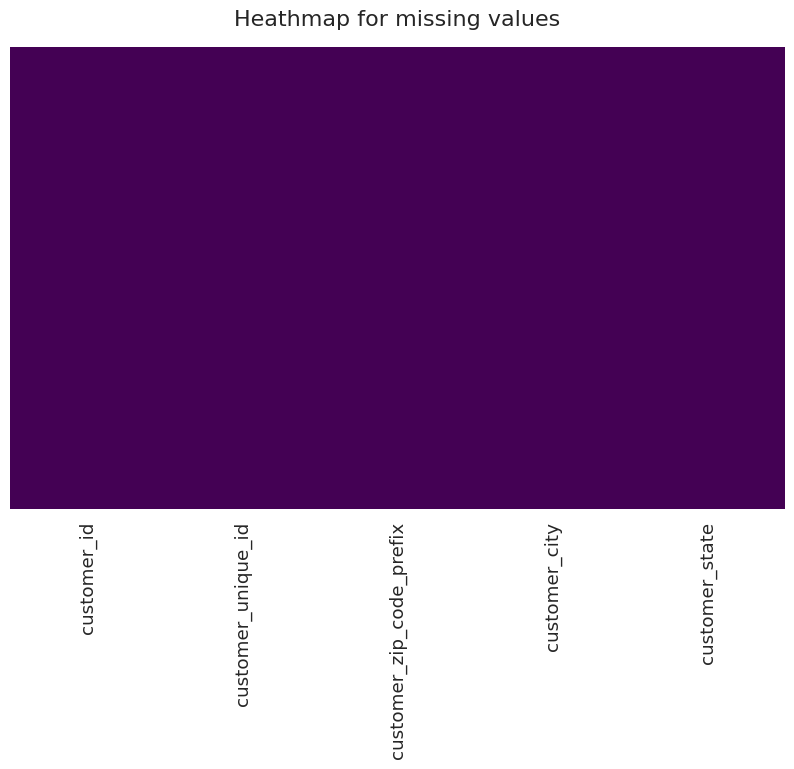


Analyzing columns: customer_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 99441, 'most_frequent': '00012a2ce6f8dcda20d059ce98491703'}
The column customer_id has more than 20 unique values.

Analyzing columns: customer_unique_id
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 96096, 'most_frequent': '8d50f5eadf50201ccdcedfb9e2ac8455'}
The column customer_unique_id has more than 20 unique values.

Analyzing columns: customer_zip_code_prefix
----------------------------------------
Statistics:
{'type': 'numeric', 'missing_values': np.int64(0), 'mean': np.float64(35137.47458291851), 'std_dev': 29797.93899620654, 'min': 1003, 'max': 99990, 'outliers': np.int64(9933)}


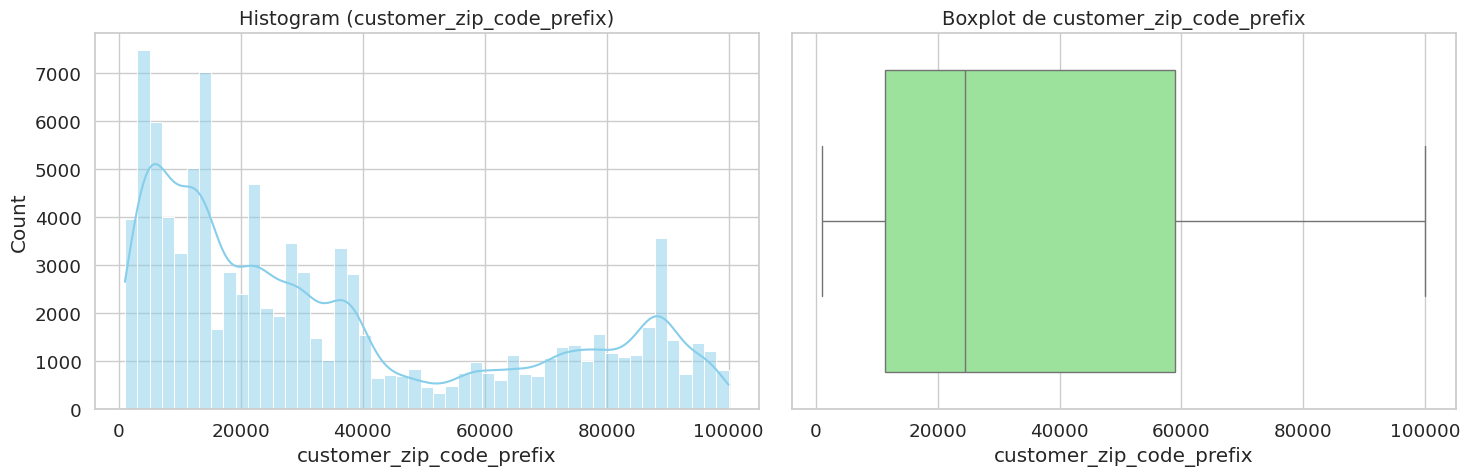


Analyzing columns: customer_city
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 4119, 'most_frequent': 'sao paulo'}
The column customer_city has more than 20 unique values.

Analyzing columns: customer_state
----------------------------------------
Statistics:
{'type': 'categorical', 'missing_values': np.int64(0), 'unique_values': 27, 'most_frequent': 'SP'}
The column customer_state has more than 20 unique values.


{'customer_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 99441,
  'most_frequent': '00012a2ce6f8dcda20d059ce98491703'},
 'customer_unique_id': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 96096,
  'most_frequent': '8d50f5eadf50201ccdcedfb9e2ac8455'},
 'customer_zip_code_prefix': {'type': 'numeric',
  'missing_values': np.int64(0),
  'mean': np.float64(35137.47458291851),
  'std_dev': 29797.93899620654,
  'min': 1003,
  'max': 99990,
  'outliers': np.int64(9933)},
 'customer_city': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 4119,
  'most_frequent': 'sao paulo'},
 'customer_state': {'type': 'categorical',
  'missing_values': np.int64(0),
  'unique_values': 27,
  'most_frequent': 'SP'}}

In [215]:
generate_data_profile (clients)

**Uniqueness 100%:**

In [216]:
check_duplicates (clients, 'customer_id')

(0,
 Empty DataFrame
 Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state]
 Index: [])

**Complitude 100%:**

In [217]:
check_missing_values (clients)

,0
customer_id,0
customer_unique_id,0
customer_zip_code_prefix,0
customer_city,0
customer_state,0


**Checking data type concistence:**

In [218]:
data_type_consistency (clients)

,Data Type
customer_id,object
customer_unique_id,object
customer_zip_code_prefix,int64
customer_city,object
customer_state,object


**Creating consumeable dataframe:**

In [219]:
clients_t = clients.copy()

**Setting costumer_id and costumer_unique_id to UUID:**

In [220]:
data_type_to_uuid (clients_t, 'customer_id')
data_type_to_uuid (clients_t, 'customer_unique_id')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e-2fba-1a1f-bc88-172c00ba8bc7,861eff47-11a5-42e4-b938-43c6dd7febb0,14409,franca,SP
1,18955e83-d337-fd6b-2def-6b18a428ac77,290c77bc-529b-7ac9-35b9-3aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00-2885-86eb-d087-12fdd0374a03,060e732b-5b29-e818-1a18-229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027b-c5c5-109e-529d-4dc6358b12c3,259dac75-7896-d24d-7702-b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab1-71c8-0ec8-364f-7c12e35b23ad,345ecd01-c38d-18a9-036e-d96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd-5d51-696b-b3d7-c6291687be6f,1a29b476-fee2-5c95-fbaf-c67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a90-17aa-05c9-a7fd-292d714858e8,d52a67c9-8be1-cf6a-5c84-435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe1-2db7-fb50-a4b2-f691faecea5e,e9f50caf-99f0-32f0-bf3c-55141f019d99,60115,fortaleza,CE
99439,56b18e21-6667-9b8a-959d-72dd06da27f9,73c2643a-0a45-8b49-f58c-ea58833b192e,92120,canoas,RS


**Setting costumer_city as STR:**

In [221]:
data_type_to_string (clients_t, 'customer_city')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e-2fba-1a1f-bc88-172c00ba8bc7,861eff47-11a5-42e4-b938-43c6dd7febb0,14409,franca,SP
1,18955e83-d337-fd6b-2def-6b18a428ac77,290c77bc-529b-7ac9-35b9-3aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00-2885-86eb-d087-12fdd0374a03,060e732b-5b29-e818-1a18-229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027b-c5c5-109e-529d-4dc6358b12c3,259dac75-7896-d24d-7702-b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab1-71c8-0ec8-364f-7c12e35b23ad,345ecd01-c38d-18a9-036e-d96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd-5d51-696b-b3d7-c6291687be6f,1a29b476-fee2-5c95-fbaf-c67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a90-17aa-05c9-a7fd-292d714858e8,d52a67c9-8be1-cf6a-5c84-435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe1-2db7-fb50-a4b2-f691faecea5e,e9f50caf-99f0-32f0-bf3c-55141f019d99,60115,fortaleza,CE
99439,56b18e21-6667-9b8a-959d-72dd06da27f9,73c2643a-0a45-8b49-f58c-ea58833b192e,92120,canoas,RS


**Setting costumer_state as categorical:**

In [222]:
data_type_to_categorical (clients_t, 'customer_state')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e-2fba-1a1f-bc88-172c00ba8bc7,861eff47-11a5-42e4-b938-43c6dd7febb0,14409,franca,SP
1,18955e83-d337-fd6b-2def-6b18a428ac77,290c77bc-529b-7ac9-35b9-3aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00-2885-86eb-d087-12fdd0374a03,060e732b-5b29-e818-1a18-229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027b-c5c5-109e-529d-4dc6358b12c3,259dac75-7896-d24d-7702-b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab1-71c8-0ec8-364f-7c12e35b23ad,345ecd01-c38d-18a9-036e-d96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd-5d51-696b-b3d7-c6291687be6f,1a29b476-fee2-5c95-fbaf-c67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a90-17aa-05c9-a7fd-292d714858e8,d52a67c9-8be1-cf6a-5c84-435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe1-2db7-fb50-a4b2-f691faecea5e,e9f50caf-99f0-32f0-bf3c-55141f019d99,60115,fortaleza,CE
99439,56b18e21-6667-9b8a-959d-72dd06da27f9,73c2643a-0a45-8b49-f58c-ea58833b192e,92120,canoas,RS


**Setting zip_code as STR**

In [223]:
data_type_to_string (clients_t, 'customer_zip_code_prefix')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e-2fba-1a1f-bc88-172c00ba8bc7,861eff47-11a5-42e4-b938-43c6dd7febb0,14409,franca,SP
1,18955e83-d337-fd6b-2def-6b18a428ac77,290c77bc-529b-7ac9-35b9-3aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00-2885-86eb-d087-12fdd0374a03,060e732b-5b29-e818-1a18-229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027b-c5c5-109e-529d-4dc6358b12c3,259dac75-7896-d24d-7702-b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab1-71c8-0ec8-364f-7c12e35b23ad,345ecd01-c38d-18a9-036e-d96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd-5d51-696b-b3d7-c6291687be6f,1a29b476-fee2-5c95-fbaf-c67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a90-17aa-05c9-a7fd-292d714858e8,d52a67c9-8be1-cf6a-5c84-435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe1-2db7-fb50-a4b2-f691faecea5e,e9f50caf-99f0-32f0-bf3c-55141f019d99,60115,fortaleza,CE
99439,56b18e21-6667-9b8a-959d-72dd06da27f9,73c2643a-0a45-8b49-f58c-ea58833b192e,92120,canoas,RS


**Checking:**

In [224]:
data_type_consistency (clients_t)

,Data Type
customer_id,object
customer_unique_id,object
customer_zip_code_prefix,string[python]
customer_city,string[python]
customer_state,category


**Saving the transformed dataframe:**

In [225]:
consumeable_dataframes.append(clients_t)


#**EXPORTING ZONE**

In [226]:
def save_dataframes(data, save_dir):
    """
    Save each DataFrame in a list as a CSV file.

    :param data: list containing variables with pandas DataFrames
    :param save_dir: directory where CSV files will be saved
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i, df in enumerate(data):
        if isinstance(df, pd.DataFrame):
            file_path = os.path.join(save_dir, f'dataframe_{i}.csv')
            df.to_csv(file_path, index=False)
        else:
            print(f"Warning: Element at index {i} is not a DataFrame.")

In [ ]:
save_dataframes(consumeable_dataframes, '')